In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import root
from scipy.interpolate import interp1d
import scienceplots
import pickle
import os
from tqdm import tqdm
from math import pi

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakePerth
from qiskit.circuit.library import SGate, TGate, TdgGate, CU1Gate
from qiskit_aer.noise import depolarizing_error
from qiskit.converters import circuit_to_dag, dag_to_circuit


plt.style.use(['science', 'notebook', 'nature'])

In [2]:
CS = SGate().control()
CT = TGate().control()
CTdg = TdgGate().control()
# CU1 = CU1Gate()



# General Tools

In [3]:
def pickle_save(obj, filename) :
    """
    Serialize and save a Python object to a binary file using the pickle module.

    Args:
    - obj: The Python object to be serialized and saved.
    - filename (str): The name of the file where the serialized object will be saved.

    Returns:
    - None: The function does not return anything, but it saves the serialized object to the specified file.

    Example:
    my_dict = {'key1': 100, 'key2': [1, 2, 3], 'key3': {'a': 1, 'b': 2}}
    pickle_save(my_dict, 'my_dict.pkl')

    This example saves the dictionary 'my_dict' to a file named 'my_dict.pkl'.
    """
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def pickle_load(filename):
    """
    Load a Python object from a binary file using the pickle module.

    Args:
    - filename (str): The name of the file from which to load the serialized object.

    Returns:
    - obj: The Python object loaded from the file.

    Example:
    loaded_dict = pickle_load('my_dict.pkl')
    print(loaded_dict)

    This example loads a dictionary from the file 'my_dict.pkl'.
    """
    with open(filename, 'rb') as file:
        loaded_obj = pickle.load(file)
    return loaded_obj

In [91]:
def create_folders(sim_folder):
    """
    Create all necessary folders for the given simulation folder.

    Args:
    - sim_folder (str): The name of the folder for which to create folders.

    Returns:
    - None: The function does not return anything but creates the necessary folders.
    """
    os.makedirs(f'./results/{sim_folder}/count/', exist_ok=True)
    os.makedirs(f'./results/{sim_folder}/figs/', exist_ok=True)
    os.makedirs(f'./results/{sim_folder}/histograms/', exist_ok=True)
    os.makedirs(f'./results/{sim_folder}/mitigation_results/', exist_ok=True)
    os.makedirs(f'./results/{sim_folder}/probs/', exist_ok=True)

In [5]:
def collect_probabilities(output_qc, path, noise_levels) :
    """
    Collect noisy probabilities for a specific quantum output across different noise levels.

    Args:
    - output_qc (str): The quantum output for which probabilities are collected ('000', '101', ...).

    Returns:
    - list: A list containing the probabilities corresponding to the specified quantum output
            for different noise levels.
    """
    p_noisy = []
    for i in range(1, len(noise_levels)+1):
        probs_noisy = pickle_load(f'{path}/probs_qc_{i}_dic.pkl')
        try :
            p_noisy.append(probs_noisy[output_qc])
        except KeyError :
            p_noisy.append(0)
    return p_noisy

In [6]:
def bound_to_0_1(dict_result_job) :
    """
    Ensure that probabilities in the given dictionary are within the [0, 1] range.

    Parameters:
    - dict_result_job (dict): A dictionary containing keys as outcomes and values as probabilities.

    Returns:
    - dict: The modified dictionary with probabilities bounded to the [0, 1] range.
    """
    for key in dict_result_job.keys() :
        probability = dict_result_job[key]
        if probability > 1 :
            dict_result_job[key] = 1
        elif probability < 0 :
            dict_result_job[key] = 0
    return dict_result_job

In [58]:
def generate_binary_values(num_bits):
    """
    Generate all possible binary representations of numbers with the given number of bits.

    Parameters:
    - num_bits (int): Number of bits in the binary representation.

    Returns:
    - list: A list of strings containing all possible binary representations.
    """
    if num_bits <= 0:
        return []

    max_value = 2 ** num_bits

    binary_values = [format(i, f'0{num_bits}b') for i in range(max_value)]

    return binary_values

if __name__ == '__main__' :
    # Example usage:
    num_bits = 3
    possible_outputs = generate_binary_values(num_bits)
    print(possible_outputs)

['000', '001', '010', '011', '100', '101', '110', '111']


# Circuit preparation

##### noise scaling

In [7]:
def closest_integer(x, d):
    """
    Finds the closest integer k to each element in an array x
    such that k = n * d + s.

    Args:
    - x: Array of real numbers
    - d: Integer divisor

    Returns:
    - k_values: Closest integers to elements in x
    - n_values: Integer quotients for each element in x
    - s_values: Remainders for each element in x
    """
    y = d * (x - 1) / 2     # real value for k to approach
    k_values = np.rint(y)
    n_values = y // d  # Integer division to find the quotient
    s_values = y % d   # Modulo operation to find the remainder

    return k_values.astype(int), n_values.astype(int), s_values.astype(int)

In [8]:
if __name__ == '__main__' :
    d = 10
    Npoints = 5

    x = np.linspace(-3, 3, Npoints)
    params_mitigation = closest_integer(x, d)

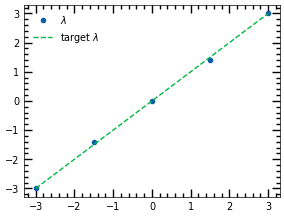

In [9]:
if __name__ == '__main__' :
    lbda = 1 + 2 * params_mitigation[0] / 10

    plt.plot(x, lbda, label=r'$\lambda$', marker='o', ls='')
    plt.plot(x, x, label='target ' + r'$\lambda$', ls='--')

    plt.legend()

##### Run circuits

In [10]:
def run_true(qc, Nshots) :
    simulator = QasmSimulator()
    return execute(qc, backend=simulator, shots=Nshots).result()

In [11]:
def run_noisy(qc, Nshots, noise_model_name, *args) :
    if noise_model_name == 'fake_perth' :
        fake_backend = FakePerth()
        noise_model = NoiseModel.from_backend(fake_backend)

    elif noise_model_name == 'depolarizing' :
        noise_model = NoiseModel()
        p = args[0]     # depolarizing noise
        error_1 = depolarizing_error(p, 1)
        error_2 = depolarizing_error(p, 2)
        noise_model.add_all_qubit_quantum_error(error_1, ['h', 'x', 's', 't', 'sdg', 'tdg'])
        noise_model.add_all_qubit_quantum_error(error_2, ['csdg', 'ctdg'])
    else :
        raise NameError('Incorrect noise model name')

    noisy_qasm_simulator  = QasmSimulator(noise_model=noise_model)

    return execute(qc, backend=noisy_qasm_simulator, shots=Nshots).result()
    

##### circuit preparation

In [12]:
def prepare_input_state(qc) :
    qc.h(0)
    qc.x(1)
    qc.h(2)
    return qc

In [13]:
# define all layers of QFT

def L0(qc):
    qc.h(0)
    qc.x(1)
    qc.h(2)
    return qc

def L0t(qc) :
    L0(qc)
    return qc


def L1(qc):
    qc.h(0)
    return qc

def L1t(qc) :
    L1(qc)
    return qc


def L2(qc) :
    qc.append(CS, [1,0])
    return qc

def L2t(qc) :
    qc.csdg(1, 0)
    return qc


def L3(qc) :
    qc.append(CT, [2,0])
    return qc 

def L3t(qc) :
    qc.append(CTdg, [2, 0])
    return qc


def L4(qc) :
    qc.h(1)
    return qc

def L4t(qc) :
    L4(qc)
    return qc


def L5(qc) :
    qc.append(CS, [2,1])
    return qc

def L5t(qc) :
    qc.csdg(2, 1)
    return qc


def L6(qc) :
    qc.h(2)
    return qc

def L6t(qc) :
    L6(qc)
    return qc


def L7(qc) :
    qc.swap(0,2)
    return qc

def L7t(qc) :
    L7(qc)
    return qc


# easy access to each layer
L = [L0, L1, L2, L3, L4, L5, L6, L7]
Lt = [L0t, L1t, L2t, L3t, L4t, L5t, L6t, L7t]
Lt.reverse()


# original circuit
def U(qc) :
    for i in range(1, 8) :
        L[i](qc)
    return qc

# and its inverse
def Ut(qc) :
    for i in range(0, 7) :
        Lt[i](qc)
    return qc


In [14]:
def build_full_circuit(layers) :
    """
    Constructs a quantum circuit consisting of multiple layers of operations.

    Args:
    - layers (list): A list of functions representing quantum operations for each layer.
                     Each function should take a QuantumCircuit as its argument and apply
                     quantum gates or operations to it.

    Returns:
    - QuantumCircuit: A constructed quantum circuit with the specified layers of operations.
                      The layers are applied sequentially with barriers between each layer,
                      and measurements are added to all qubits at the end of the circuit.
    """
    qc = QuantumCircuit(3)
    prepare_input_state(qc)
    qc.barrier()
    for i, layer in enumerate(layers) :
        layer(qc)
        if i != len(layers)-1 :
            qc.barrier()
    qc.measure_all()
    return qc


def select_layers_from_left(d, s) :
    """
    Selects layers from left based on the provided parameters.

    Args:
    - d (int): The total number of layers.
    - s (int): The number of layers to select from the left.

    Returns:
    - list: A list containing selected layers from the left based on the parameters.
        
    Example:
    s = 3, d = 8 returns:
    [L7t L6t L5t L5 L6 L7]
    """  
    Ls = L[d-s:]
    Lst = Lt[:s]
    return Lst + Ls


def loop(G, Gt, n) :
    """
    Constructs a list representing a loop of gates and their dagger counterparts.

    Args:
    - G: A quantum gate or operation.
    - Gt: The dagger (conjugate transpose) of the gate 'G'.
    - n (int): The number of repetitions for constructing the loop.

    Returns:
    - list: A list containing the gates and their dagger counterparts forming a loop.
            The list alternates between 'Gt' and 'G' repeated 'n' times.

    Example:
    n=2 returns the list of gates corresponding to
    (Gt*G)**2
    """
    L = []
    for i in range(n):
        L.append(Gt)
        L.append(G)
    return L


def circuit_folding(target_noise_levels) :
    """
    Constructs a folded quantum circuit based on target noise levels.

    Args:
    - target_noise_levels (array of floats): The desired noise levels for the folded circuit.

    Returns:
    - Tuple: A tuple containing the calculated noise levels after folding and the folded quantum circuit.
             The folding process involves constructing a folded circuit based on the target noise levels.
             The folded circuit comprises multiple layers of quantum gates and their repetitions 
             based on the noise levels and predefined parameters.
    """
    d = 8   # by construction of QFT
    ks, ns, ss = closest_integer(target_noise_levels, d)
    noise_levels = 1 + 2 * ks / d
    
    qc_list = []
    associated_layers_list = []
    # for i, n in enumerate(ns) :
    for n, s in zip(ns, ss) :
        layers = [U, *loop(U, Ut, n), *select_layers_from_left(d, s)]
        qc = build_full_circuit(layers)
        qc_list.append(qc)
        associated_layers_list.append(layers)

    return noise_levels, qc_list, associated_layers_list
    

Original QFT : 

$U$

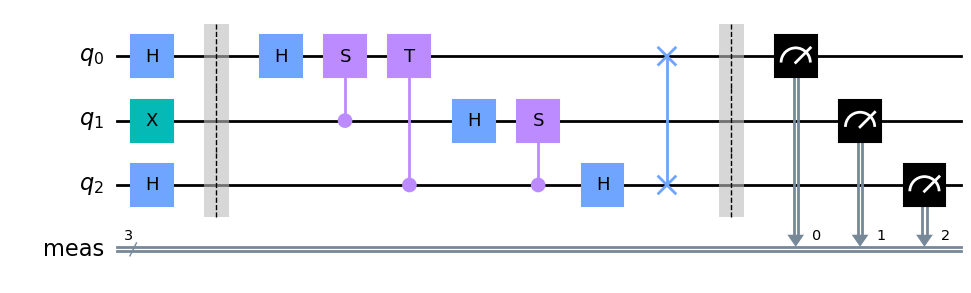

In [15]:
if __name__ == '__main__' :
    # original QFT 
    gates_qft = [U]
    qft = build_full_circuit(gates_qft)
    display(qft.draw(output='mpl'))

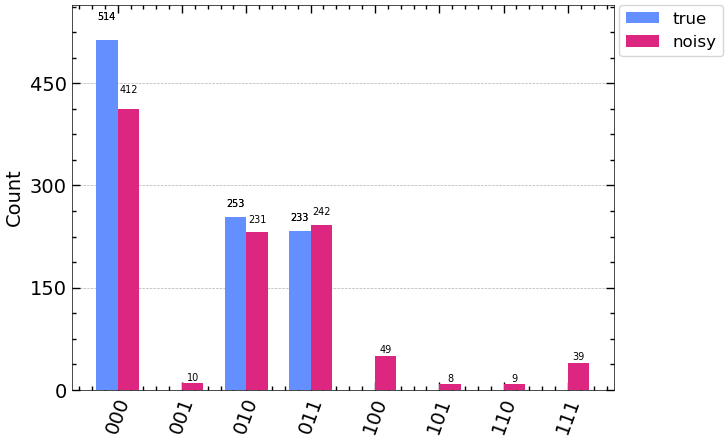

In [16]:
if __name__ == '__main__' :
    Nshots = 1000
    depolarizing_noise = 0.05
    results_true = run_true(qft, Nshots)
    results_noisy = run_noisy(qft, Nshots, 'depolarizing', depolarizing_noise)
    display(plot_histogram([results_true.get_counts(), results_noisy.get_counts()], legend=['true', 'noisy']))       # , color=['green', 'red'])



Check the inverse circuits: 

$U U^\dag L_1 L_1^\dag L_2 L_2^\dag L_3 L_3^\dag L_4 L_4^\dag L_5 L_5^\dag L_6 L_6^\dag L_7 L_7^\dag$

$\to$ expected to act as the identity

(without layer 0)

In [17]:
if __name__ == '__main__' :
    LLt_all = []
    for i in range(1, len(L)) :
        LLt_all.append(L[i])
        LLt_all.append(Lt[7-i])
    print(LLt_all)

[<function L1 at 0x00000192C054E160>, <function L1t at 0x00000192C054D800>, <function L2 at 0x00000192C054D8A0>, <function L2t at 0x00000192C04D77E0>, <function L3 at 0x00000192C04D79C0>, <function L3t at 0x00000192C05E85E0>, <function L4 at 0x00000192C05E8D60>, <function L4t at 0x00000192C05E8E00>, <function L5 at 0x00000192C05E8EA0>, <function L5t at 0x00000192C05E8F40>, <function L6 at 0x00000192C05E8FE0>, <function L6t at 0x00000192C05E9080>, <function L7 at 0x00000192C05E9120>, <function L7t at 0x00000192C05E91C0>]


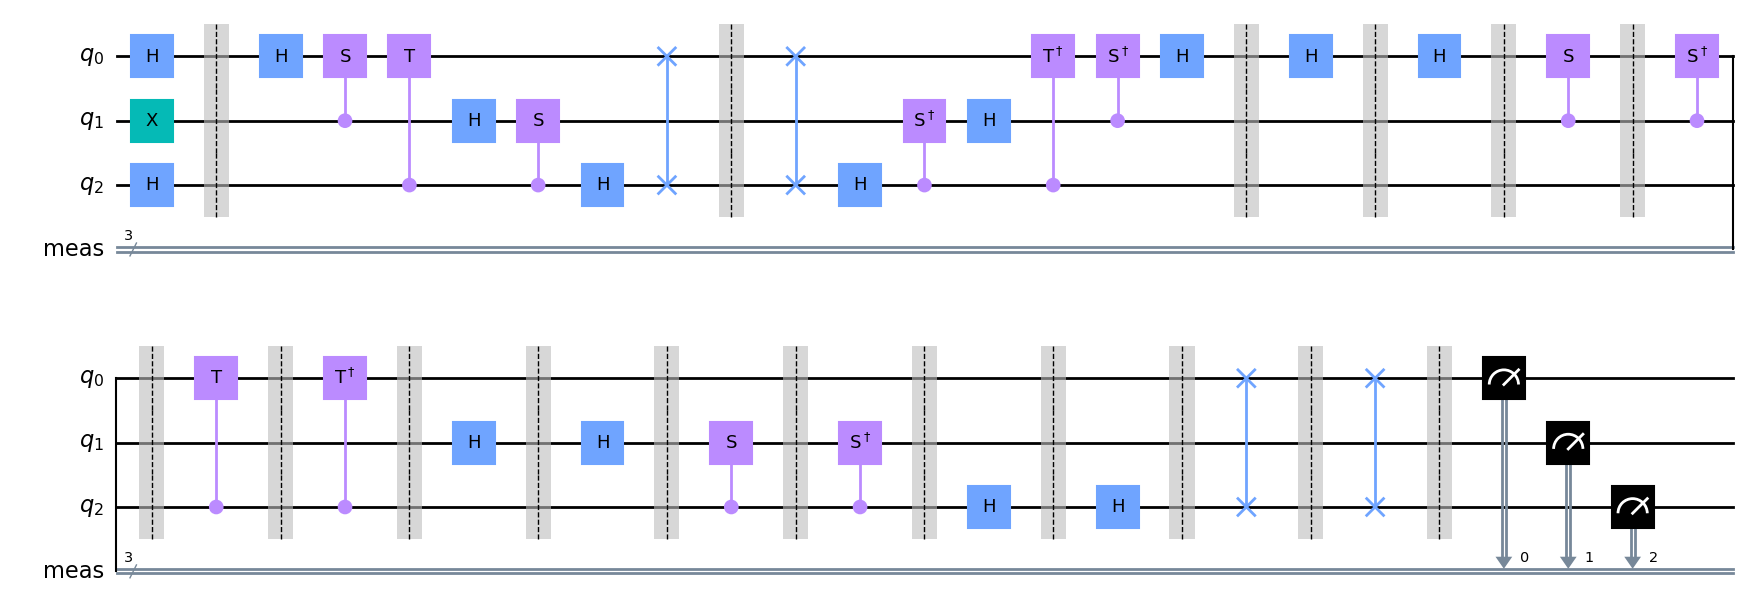

In [18]:
if __name__ == '__main__' :
    qft = build_full_circuit([U, Ut, *LLt_all])
    display(qft.draw(output='mpl'))

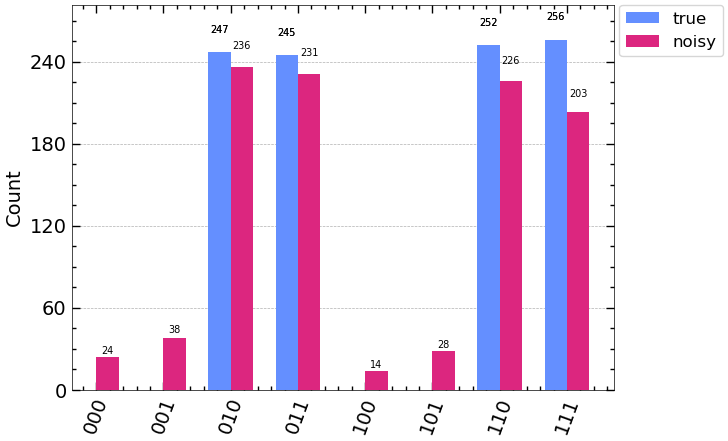

In [19]:
if __name__ == '__main__' :
    # expect 1/4 probabilities for ['010', '111', '110', '011']
    Nshots = 1000
    results_true = run_true(qft, Nshots)
    results_noisy = run_noisy(qft, Nshots, 'fake_perth')
    display(plot_histogram([results_true.get_counts(), results_noisy.get_counts()], legend=['true', 'noisy']))       # , color=['green', 'red'])



##### Circuit folding

In [20]:
if __name__ == '__main__' :
    noise_levels = np.array([2.5, 4.3])
    lambdas, qc_list, layers_list = circuit_folding(noise_levels)

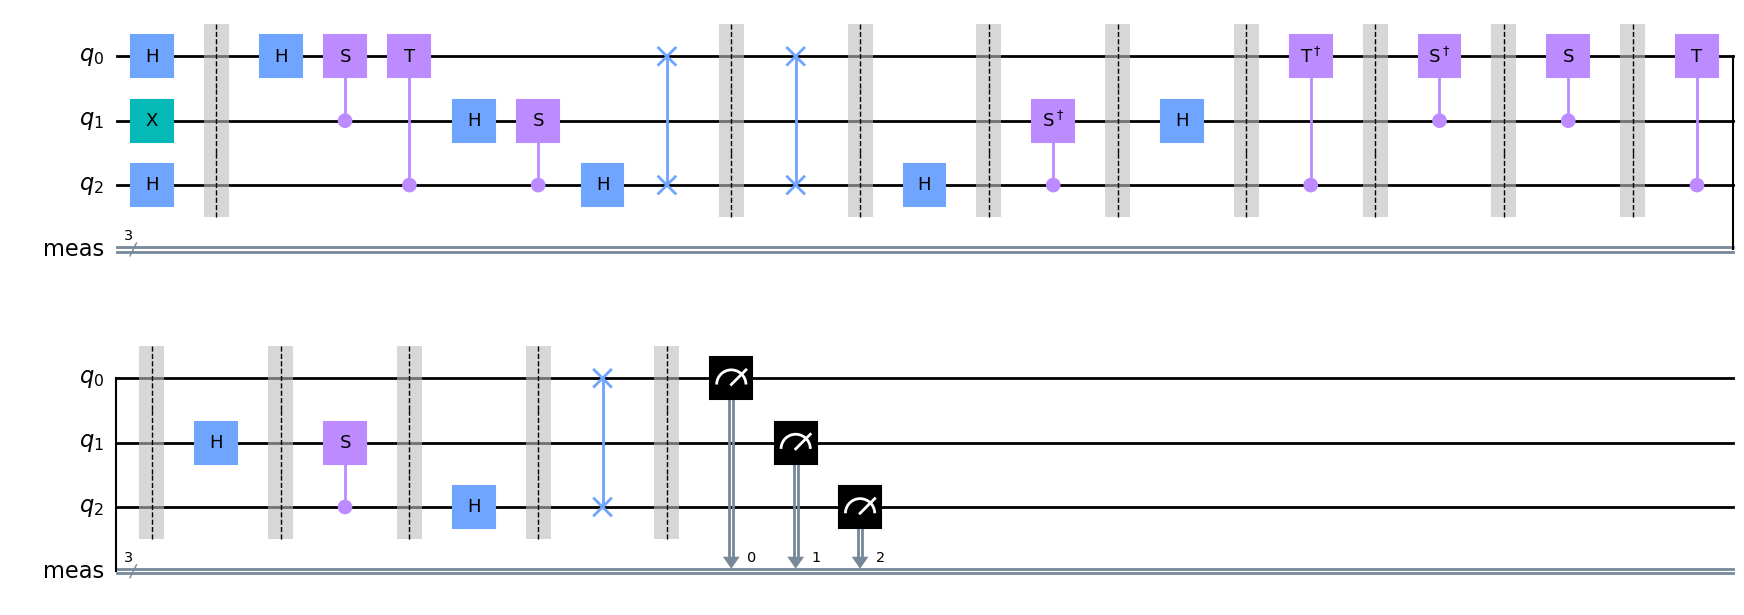

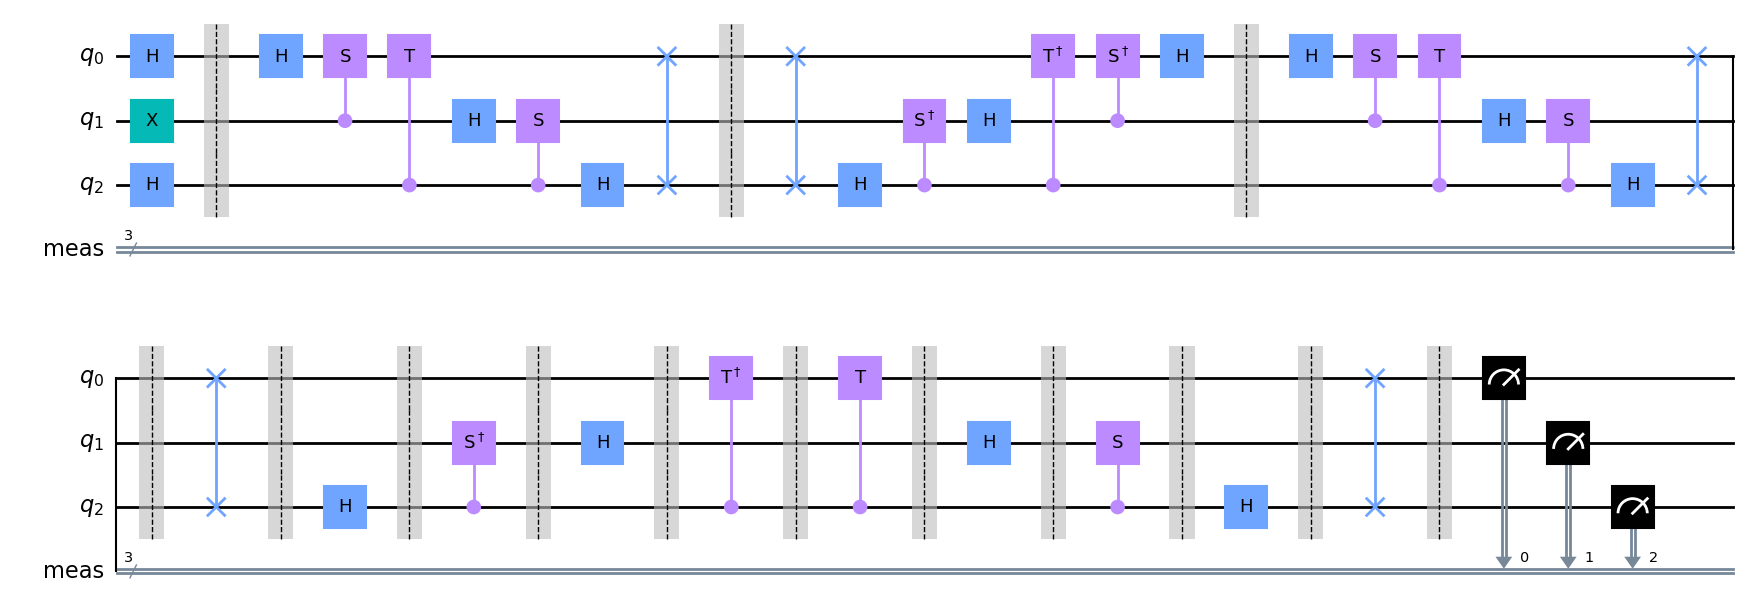

In [21]:
if __name__ == '__main__' :
    for qc in qc_list :
        display(qc.draw(output='mpl'))

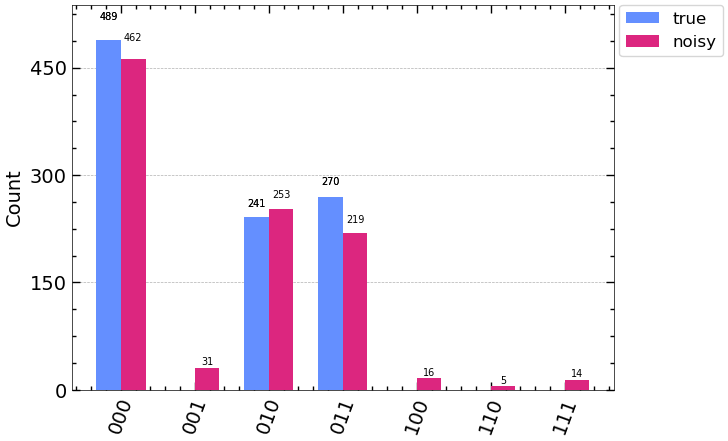

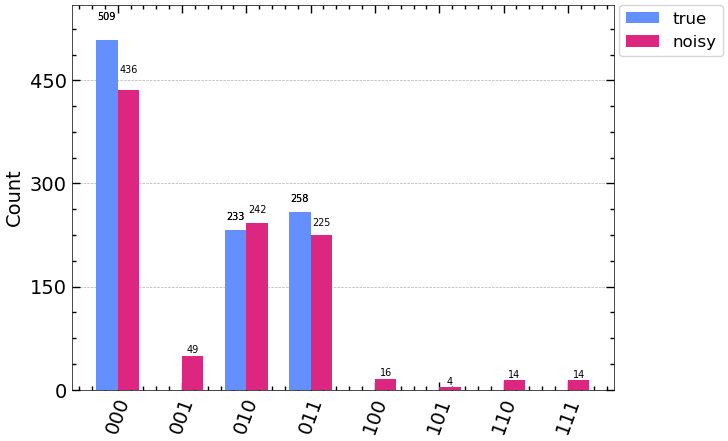

In [22]:
if __name__ == '__main__' :
    for qc in qc_list :
        Nshots = 1000
        results_true = run_true(qc, Nshots)
        results_noisy = run_noisy(qc, Nshots, 'fake_perth')
        display(plot_histogram([results_true.get_counts(), results_noisy.get_counts()], legend=['true', 'noisy']))       # , color=['green', 'red'])
        

# Extrapolation

##### model functions

In [23]:
def z_polynomial(x, *coeffs):
    """
    Polynomial function of degree len(coeffs) - 1.

    Args:
    - x: Input variable
    - *coeffs: Coefficients of the polynomial

    Returns:
    - value: Result of the polynomial function at x
    """
    return np.polyval(coeffs, x)

$$ f(\lambda) = a \pm {\rm e}^{z(\lambda)}$$ 
where $z(\lambda)$ is a polynomial

In [24]:
def polyexp(x, s, a, *z_coeffs):
    """
    Poly-exponential function: a +/- exp(z(x)), where z is a polynomial.

    Args:
    - x: Input variable
    - s: sign +/- 1
    - a: Parameter 'a'
    - *z_coeffs: Coefficients of the polynomial z(x)

    Returns:
    - value: Result of the model function at x
    """
    z_x = z_polynomial(x, *z_coeffs)
    return a + s * np.exp(z_x)

##### fits

In [25]:
def fit_polynomial(x, y, degree):
    """
    Fits a polynomial of a specified degree to the given data points.

    Args:
    - x: Independent variable values (input data)
    - y: Dependent variable values (output data)
    - degree: Degree of the polynomial to be fitted

    Returns:
    - coeffs: Coefficients of the fitted polynomial
    """
    coeffs = np.polyfit(x, y, degree)
    return coeffs


def fit_richardson(x, y):
    """
    Performs Richardson extrapolation by fitting polynomials of maximum degree
    and returns the coefficients of the fit.

    Args:
    - x: Independent variable values (input data)
    - y: Dependent variable values (output data)

    Returns:
    - coeffs: Coefficients of the fitted polynomial
    """
    degree = len(x)
    coefficients = fit_polynomial(x, y, degree)
    return coefficients


def fit_polyexp_sign(x, y, s, degree, *a):
    """
    Fits the poly-exponential function a + s * exp(z(x)) to the given data points using curve fitting.
    if parameter *a is not specified, 'a' is also a parameter to infer.

    Args:
    - x: Independent variable values (input data)
    - y: Dependent variable values (output data)
    - s: sign to use in the fit (not a parameter to infer here)
    - degree: Degree of the polynomial z(x)
    - *a: value of a if a is known (float)

    Returns:
    - Optimal parameters: a, z_coeffs
    - error made by the fit: loss
    """
    def polyexp_plus(x, a, *z_coeffs) :
        return polyexp(x, 1, a, *z_coeffs)

    def polyexp_minus(x, a, *z_coeffs) :
        return polyexp(x, -1, a, *z_coeffs)

    if a == () :    # a unknown
        # Initial guess for parameters
        initial_guess = [-0.05] * (degree + 1)  # Initial guess for polynomial coefficients
        initial_guess.insert(0, 1.0)  # Initial guess for 'a'
        try :

            # Perform curve fitting to find optimal parameters
            if s == 1 :
                optimal_params, _ = curve_fit(polyexp_plus, x, y, p0=initial_guess, maxfev=2000)
            else :
                optimal_params, _ = curve_fit(polyexp_minus, x, y, p0=initial_guess, maxfev=2000)

            # Extracting 'a' and coefficients of the polynomial z(x)
            a = optimal_params[0]
            z_coeffs = optimal_params[1:]

            loss = np.average(np.abs(polyexp(x, s, a, *z_coeffs) - y))

        except RuntimeError :
            a, z_coeffs = initial_guess[0], initial_guess[1:]
            loss = np.inf 

        return a, z_coeffs, loss

    else :      # a is known
        # change of coordinates
        eps = 0.01     # regularization
        a = a[0]
        y_prime = np.log(np.abs(y - a) + eps)

        z_coeffs = fit_polynomial(x, y_prime, degree)

        return a, z_coeffs


def fit_polyexp(x, y, degree, *a):
    """
    Fit a function of the form a + exp(z(x)) or a - exp(z(x)) to the given data.

    Parameters:
    - x (array-like): Independent variable data.
    - y (array-like): Dependent variable data.
    - degree (int): Degree of the polynomial z(x).
    - *a (float): Additional parameters for the fit.

    Returns:
    - tuple: Fitted parameters (a, z_coeffs), where a is the constant term
      and z_coeffs are the coefficients of the polynomial z(x).

    Note:
    The function fits two cases: a + exp(z(x)) and a - exp(z(x)), compares the
    losses for both cases, and returns the parameters corresponding to the
    case with the lower loss.
    """
    
    s = 1   # case a + exp(z(x))
    a_plus, z_coeffs_plus, loss_plus = fit_polyexp_sign(x, y, s, degree, *a)
    
    s = -1   # case a - exp(z(x))
    a_minus, z_coeffs_minus, loss_minus = fit_polyexp_sign(x, y, s, degree, *a)

    if loss_plus > loss_minus :
        a, z_coeffs = a_minus, z_coeffs_minus
        s = -1
    else :
        a, z_coeffs = a_plus, z_coeffs_plus
        s = 1

    return s, a, z_coeffs


def fit_exp(x, y, *a):
    """
    Performs exponential fit by calling fit_polyexp(x, y, 1, *a).
    Associated model function: a + exp(z0 + z1*\lambda) 
    if parameter *a is not specified, 'a' is also a parameter to infer.

    Args:
    - x: Independent variable values (input data)
    - y: Dependent variable values (output data)
    - *a: Parameter for the model (float)

    Returns:
    - Optimal parameters for the fitted function (using fit_polyexp)
    """
    return fit_polyexp(x, y, 1, *a)


##### extrapolation

In [26]:
def extrapolate(model_func, params):
    """
    Calculates the value of the model function at x = 0.

    Args:
    - model_func: Model function
    - params: Parameters of the model function

    Returns:
    - f_at_zero: Value of the function at x = 0
    """
    # Call the model function with x = 0
    f_at_zero = model_func(0, *params)
    return f_at_zero

##### mitigation

In [27]:
def label_of(zne_type) :
    if zne_type == 'exp' :
        return 'ZNE exponential'
    elif zne_type == 'lin' :
        return r'ZNE linear ($d=1$)'
    elif zne_type == 'quad' :
        return r'ZNE quadratic ($d=2$)'
    elif zne_type == 'rich_d3' :
        return r'ZNE Richardson ($d=3$)'
    else :
        raise NameError('Incorrect zne_type value')


In [28]:
def mitigate_exp(noise_levels, p_noisy) :
    """
    Mitigates noise in quantum data using an exponential fit and extrapolation.

    Args:
    - noise_levels (array-like): The noise levels used during data collection.
    - p_noisy (array-like): The noisy quantum data corresponding to the given noise levels.

    Returns:
    - Tuple: A tuple containing the mitigated data, extrapolated x values, y values of the smoothed curve,
             the coefficient 'a_exp' of the exponential fit, and the 'z_coefficients_exp' for the polynomial
             part of the fit.
    """
    sign, a_exp, z_coefficients_exp = fit_exp(noise_levels, p_noisy)
    p_extrapolated = extrapolate(polyexp, [sign, a_exp, *z_coefficients_exp])
    x = np.linspace(0, max(noise_levels), 100)  # Create a range of x values for smooth curve
    y = polyexp(x, sign, a_exp, *z_coefficients_exp)
    return p_extrapolated, x, y, sign, a_exp, z_coefficients_exp

In [29]:
def mitigate_richardson_d3(noise_levels, p_noisy) :
    # degree 3
    indices_to_interpolate = np.array([1, int(1.5/6*len(noise_levels)), int(2/6*len(noise_levels)), int(2.5/6*len(noise_levels))])

    richardson_coeffs = fit_richardson(np.array(noise_levels)[indices_to_interpolate], np.array(p_noisy)[indices_to_interpolate])
    p_extrapolated = extrapolate(z_polynomial, richardson_coeffs)
    x = np.linspace(0, max(noise_levels), 100)  # Create a range of x values for smooth curve
    y = np.polyval(richardson_coeffs, x)
    return p_extrapolated, x, y, richardson_coeffs


In [30]:
def mitigate_poly(noise_levels, p_noisy, zne_type) :
    indices_to_interpolate = np.arange(0, 5, 1)
    x_interpolate = np.array(noise_levels)[indices_to_interpolate]
    y_interpolate = np.array(p_noisy)[indices_to_interpolate]

    if zne_type == 'lin' :
        z_coeffs = fit_polynomial(x_interpolate, y_interpolate, degree=1)
    else :
        z_coeffs = fit_polynomial(x_interpolate, y_interpolate, degree=2)
        
    p_extrapolated = extrapolate(z_polynomial, z_coeffs)
    x = np.linspace(0, max(noise_levels), 100)  # Create a range of x values for smooth curve
    y = np.polyval(z_coeffs, x)
    return p_extrapolated, x, y, z_coeffs

In [31]:
def mitigate(zne_type, noise_levels, p_noisy, flag_dic_output) :

    if zne_type == 'exp' :
        p_extrapolated, x_model, y_model, s_exp, a_exp, z_coefficients_exp = mitigate_exp(noise_levels, p_noisy)
        dic_output = {
            'p_extrapolated': p_extrapolated,
            'x_model': x_model,
            'y_model': y_model,
            'params_model': [s_exp, a_exp, z_coefficients_exp]
        }

    elif zne_type == 'rich_d3' :
        p_extrapolated, x_model, y_model, richardson_coeffs = mitigate_richardson_d3(noise_levels, p_noisy)
        dic_output = {
            'p_extrapolated': p_extrapolated,
            'x_model': x_model,
            'y_model': y_model,
            'params_model': richardson_coeffs
        }

    elif zne_type == 'lin' or zne_type == 'quad' :
        p_extrapolated, x_model, y_model, z_coeffs = mitigate_poly(noise_levels, p_noisy, zne_type)
        dic_output = {
            'p_extrapolated': p_extrapolated,
            'x_model': x_model,
            'y_model': y_model,
            'params_model': z_coeffs
        }

    else :
        raise NameError("Incorrect zne_type value")
    
    if flag_dic_output == 1 :
        return p_extrapolated, x_model, y_model, dic_output
    else :
        return p_extrapolated, x_model, y_model

##### fit tests

Coefficients of the fitted polynomial: [ 0.01952685 -0.24964063  3.84845606]
Coefficients using Richardson extrapolation: [-7.71383539e-04  8.91802182e-03 -8.00925474e-03 -2.64759232e-01
  1.29137969e+00 -2.37015187e+00  4.97809322e+00]
Parameter 'a' and 's': 0.8523217541970544 1
Coefficients of the polynomial z(x) a unknown: [-0.00154881  0.0231275  -0.14319342  1.14411559]
Coefficients of the polynomial z(x) a known: [-0.37559232 -0.00508367]


C:\Users\antho\AppData\Local\Temp\ipykernel_14536\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


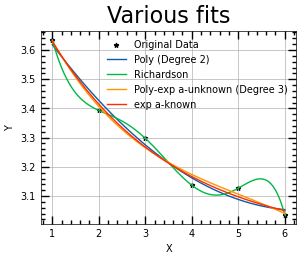

In [32]:
if __name__ == '__main__' :
    # Generating some sample data
    x_data = np.array([1, 2, 3, 4, 5, 6])
    # y_data = polyexp(x_data, 3, *[-0.03, -0.4, -0.5]) + np.random.normal(0, 0.05, len(y_data))
    y_data = np.array([3.63469919, 3.39309445, 3.2975466 , 3.13706804, 3.12708822, 3.03572974])


    # Fit a polynomial to the sample data
    degree_to_fit = 2
    coefficients = fit_polynomial(x_data, y_data, degree_to_fit)
    print("Coefficients of the fitted polynomial:", coefficients)

    # with richardson
    richardson_coeffs = fit_richardson(x_data, y_data)
    print("Coefficients using Richardson extrapolation:", richardson_coeffs)

    # poly-exp, a unknown
    degree_to_fit_polyexp = 3
    sign, a_param, z_coefficients_a_unknown = fit_polyexp(x_data, y_data, degree_to_fit_polyexp)
    print("Parameter 'a' and 's':", a_param, sign)
    print("Coefficients of the polynomial z(x) a unknown:", z_coefficients_a_unknown)

    # # poly-exp, a known
    # a = 0.8521698213202102
    # degree_to_fit_polyexp = 3
    # a, z_coefficients_a_known = fit_polyexp(x_data, y_data, degree_to_fit_polyexp, a)
    # print("Coefficients of the polynomial z(x) a known:", z_coefficients_a_known)

    # exp, a unknown
    sign_exp, a_exp, z_coefficients_exp = fit_exp(x_data, y_data)
    print("Coefficients of the polynomial z(x) a known:", z_coefficients_exp)


    x_range = np.linspace(min(x_data), max(x_data), 100)  # Create a range of x values for smooth curve
    fitted_curve = np.polyval(coefficients, x_range)  # Evaluate the fitted polynomial for the x values
    fitted_curve_richardson = np.polyval(richardson_coeffs, x_range)  # Evaluate the fitted polynomial for the x values



    # Plotting the data and the fitted curve
    plt.scatter(x_data, y_data, label='Original Data', color='black', marker='*')
    plt.plot(x_range, fitted_curve, label='Poly (Degree {})'.format(degree_to_fit))
    plt.plot(x_range, fitted_curve_richardson, label='Richardson')
    plt.plot(x_range, polyexp(x_range, sign, a_param, *z_coefficients_a_unknown), label='Poly-exp a-unknown (Degree {})'.format(degree_to_fit_polyexp))
    # plt.plot(x_range, polyexp(x_range, a, *z_coefficients_a_known), label='Poly-exp a-known (Degree {})'.format(degree_to_fit_polyexp))
    plt.plot(x_range, polyexp(x_range, sign_exp, a_exp, *z_coefficients_exp), label='exp a-known')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Various fits')
    plt.legend()
    plt.grid(True)
    plt.show()



##### Extrapolation tests

Poly extrapolated at:		 3.8484560600000015
Richardson extrapolated at:	 4.97809322191628
Poly-exp (a-u) extrapolated at:	 3.9919851306495975
exp (a-k) extrapolated at:	 3.940243745211721


C:\Users\antho\AppData\Local\Temp\ipykernel_14536\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)


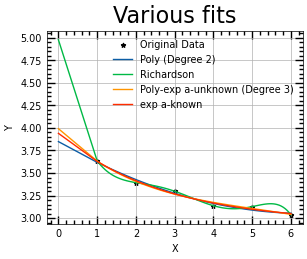

In [33]:
if __name__ == '__main__' :
    # Generating some sample data
    x_data = np.array([1, 2, 3, 4, 5, 6])
    # y_data = polyexp(x_data, 3, *[-0.03, -0.4, -0.5]) + np.random.normal(0, 0.05, len(y_data))
    y_data = np.array([3.63469919, 3.39309445, 3.2975466 , 3.13706804, 3.12708822, 3.03572974])




    # Fit a polynomial to the sample data
    degree_to_fit = 2
    coefficients = fit_polynomial(x_data, y_data, degree_to_fit)
    print("Poly extrapolated at:\t\t", extrapolate(z_polynomial, coefficients))

    # with richardson
    richardson_coeffs = fit_richardson(x_data, y_data)
    print("Richardson extrapolated at:\t", extrapolate(z_polynomial, richardson_coeffs))

    # poly-exp, a unknown
    degree_to_fit_polyexp = 3
    sign, a_param, z_coefficients_a_unknown = fit_polyexp(x_data, y_data, degree_to_fit_polyexp)
    print("Poly-exp (a-u) extrapolated at:\t", extrapolate(polyexp, [sign, a_param, *z_coefficients_a_unknown]))


    # # poly-exp, a known
    # a = 0.8521698213202102
    # degree_to_fit_polyexp = 3
    # a, z_coefficients_a_known = fit_polyexp(x_data, y_data, degree_to_fit_polyexp, a)
    # print("Poly-exp (a-k) extrapolated at:\t", extrapolate(polyexp, [a, *z_coefficients_a_known]))


    # exp, a unknown
    sign_exp, a_exp, z_coefficients_exp= fit_exp(x_data, y_data)
    print("exp (a-k) extrapolated at:\t", extrapolate(polyexp, [sign_exp, a_exp, *z_coefficients_exp]))



    x_range = np.linspace(min(x_data), max(x_data), 100)  # Create a range of x values for smooth curve
    x_range = np.insert(x_range, 0, 0)  # to extrapolate

    fitted_curve = np.polyval(coefficients, x_range)  # Evaluate the fitted polynomial for the x values
    fitted_curve_richardson = np.polyval(richardson_coeffs, x_range)  # Evaluate the fitted polynomial for the x values



    # Plotting the data and the fitted curve
    plt.scatter(x_data, y_data, label='Original Data', color='black', marker='*')
    plt.plot(x_range, fitted_curve, label='Poly (Degree {})'.format(degree_to_fit))
    plt.plot(x_range, fitted_curve_richardson, label='Richardson')
    plt.plot(x_range, polyexp(x_range, sign, a_param, *z_coefficients_a_unknown), label='Poly-exp a-unknown (Degree {})'.format(degree_to_fit_polyexp))
    # plt.plot(x_range, polyexp(x_range, a, *z_coefficients_a_known), label='Poly-exp a-known (Degree {})'.format(degree_to_fit_polyexp))
    plt.plot(x_range, polyexp(x_range, sign_exp, a_exp, *z_coefficients_exp), label='exp a-known')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Various fits')
    plt.legend()
    plt.grid(True)
    plt.show()



# Main

save simulation results:
- index 0: noiseless simulation
- index i=1: normal noise level
- index i>=1: noisy simulations, ordered by noise_levels

### main create data (several realisations for the same set of parameters)

In [92]:
def create_run_circuits(sim_folder, zne_type, nreps, folding, possible_outputs, Nshots, noise_type, noise_levels, *params_noise) :
    
    os.makedirs(f'./results/{sim_folder}/circuits/', exist_ok=True)
    _, qc_list, _ = folding(noise_levels)

    print('\ndata generation')

    for r in tqdm(range(nreps)) :
        
        create_folders(f'{sim_folder}/rep_{r}')

        # run noisy circuits
        for i, qc in enumerate(qc_list) :
            filename_count = f'./results/{sim_folder}/rep_{r}/count/count_qc_{i+1}_dic.pkl'
            filename_probs = f'./results/{sim_folder}/rep_{r}/probs/probs_qc_{i+1}_dic.pkl'
            results_noisy = run_noisy(qc, Nshots, noise_type, *params_noise)
            count = results_noisy.get_counts()
            probabilities = {}
            for output_qc in count.keys() :
                probabilities[output_qc] = count[output_qc] / Nshots
            pickle_save(count, filename=filename_count)
            pickle_save(probabilities, filename=filename_probs)
        
        # noiseless circuit
        results_true = run_true(qc_list[0], Nshots)
        count = results_true.get_counts()
        pickle_save(count, filename=f'./results/{sim_folder}/rep_{r}/count/count_qc_{0}_dic.pkl')
        probabilities = {}
        for output_qc in count.keys() :
                probabilities[output_qc] = count[output_qc] / Nshots
        pickle_save(probabilities, filename=f'./results/{sim_folder}/rep_{r}/probs/probs_qc_{0}_dic.pkl')

        # monitore probabilities
        for output_qc in possible_outputs :
            ps = []
            for i in range(len(noise_levels)):
                probabilities = pickle_load(f'./results/{sim_folder}/rep_{r}/probs/probs_qc_{i+1}_dic.pkl')
                try :
                    ps.append(probabilities[output_qc])
                except KeyError :
                    ps.append(0)
                

            p_noisy = ps
            # p_noiseless = [pickle_load(f'./results/{sim_folder}/rep_{r}/probs/probs_qc_{0}_dic.pkl')[output_qc]]
            
            _, _, _, dic_output = mitigate(zne_type, noise_levels, p_noisy, flag_dic_output=1)

            pickle_save(dic_output, f'./results/{sim_folder}/rep_{r}/mitigation_results/{output_qc}')

In [35]:
def plot_mitigation_analysis(sim_folder, zne_type, nreps, possible_outputs, noise_levels) :
    print('\n\nmitigation analysis')
    
    for r in tqdm(range(nreps)) :

        mitigated = {}
        noisy = {}
        noiseless = {}

        for output_qc in possible_outputs :
            # mitigation results
            mitigation_results = pickle_load(f'./results/{sim_folder}/rep_{r}/mitigation_results/{output_qc}')
            p_extrapolated = mitigation_results['p_extrapolated']
            x_model = mitigation_results['x_model'] 
            y_model = mitigation_results['y_model'] 

            # true probability
            probs_noiseless = pickle_load(f'./results/{sim_folder}/rep_{r}/probs/probs_qc_{0}_dic.pkl')
            try :
                p_noiseless = probs_noiseless[output_qc]
            except KeyError :
                p_noiseless = 0

            # noisy data
            p_noisy = collect_probabilities(output_qc, f'./results/{sim_folder}/rep_{r}/probs', noise_levels)

            # prepare for histogram
            mitigated[output_qc] = p_extrapolated
            noiseless[output_qc] = p_noiseless
            noisy[output_qc] = p_noisy[0]
            

            plt.plot(x_model, y_model, ls='--', color='red', label='model', zorder=0)
            scat = plt.scatter([0], p_noiseless, marker='*', s=40, color='black', label='noiseless', zorder=3)                     # noiseless
            plt.scatter(noise_levels, p_noisy, s=8, label='noisy', zorder=1)         # noisy
            plt.scatter([0], p_extrapolated, marker='s', color='purple', s=20, label=label_of(zne_type), zorder=2)   # mitigated     # scat.get_facecolor()[0]
            plt.xlabel(r'Noise scaling, $\lambda$')
            plt.ylabel(rf'Probability, $P_{{{output_qc}}}$')
            plt.legend()
            plt.savefig(fname=f'./results/{sim_folder}/rep_{r}/figs/ZNE_{output_qc}.pdf')
            if output_qc == possible_outputs[0] :
                plt.show()
            else :
                plt.close()

        pickle_save(mitigated, f'./results/{sim_folder}/rep_{r}/histograms/mitigated_dic.pkl')
        pickle_save(noisy, f'./results/{sim_folder}/rep_{r}/histograms/noisy_dic.pkl')
        pickle_save(noiseless, f'./results/{sim_folder}/rep_{r}/histograms/noiseless_dic.pkl')

In [36]:
def save_comparison_histogram(sim_folder, zne_type, nreps) :
    print('\nhistograms')

    for r in tqdm(range(nreps)) :

        mitigated = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/mitigated_dic.pkl')
        noisy = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/noisy_dic.pkl')
        noiseless = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/noiseless_dic.pkl')

        mitigated = bound_to_0_1(mitigated)

        plot_histogram([noiseless, noisy, mitigated], legend=['noiseless', 'noisy', label_of(zne_type)], filename=f'./results/{sim_folder}/rep_{r}/figs/histogram_comp_noisy_noiseless_mitigation.pdf')     

    last_vals = [noiseless, noisy, mitigated]
    last_legend = ['noiseless', 'noisy', label_of(zne_type)]

    return last_vals, last_legend


In [37]:
def save_decrease_in_error(sim_folder, nreps, possible_outputs) :
    print('\nerror comparison')
    for r in tqdm(range(nreps)) :

        mitigated = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/mitigated_dic.pkl')
        noisy = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/noisy_dic.pkl')
        noiseless = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/noiseless_dic.pkl')

        Ems = []
        Eus = []
        for output_qc in possible_outputs :
            Ems.append(np.abs(noiseless[output_qc] - mitigated[output_qc]))
            Eus.append(np.abs(noiseless[output_qc] - noisy[output_qc]))
        Em = np.array(Ems)
        Eu = np.array(Eus)

        plt.hist(Eu / Em, bins=15)
        plt.xlabel(r'Decrease in error $= E_u/E_m$')
        plt.ylabel(r'Number of occurences')
        plt.savefig(fname=f'./results/{sim_folder}/rep_{r}/figs/decrease_in_error.pdf')  # ZNE exponential
        plt.close()

    last_Em, last_Eu = Em, Eu
    return last_Eu, last_Em

### main gather data for statistics (put all realisations associated with the same set of parameters to compute the statistics)

In [38]:
def compute_statistics(sim_folder, nreps, possible_outputs, noise_levels) :

    os.makedirs(f'./results/{sim_folder}/stats/fig_probs', exist_ok=True)

    dic_p_mitigated_avg = {}
    dic_p_noiseless_avg = {}
    dic_p_noisy_avg = {}

    dic_p_mitigated_std = {}
    dic_p_noiseless_std = {}
    dic_p_noisy_std = {}

    p_mitigated = np.zeros(nreps) 
    p_noiseless = np.zeros(nreps) 
    p_noisy = np.zeros((nreps, len(noise_levels))) 

    for output_qc in possible_outputs :
        for r in range(nreps) :

            # ZNE
            mitigated = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/mitigated_dic.pkl') 
            p_mitigated[r] = mitigated[output_qc]       

            # true probability
            probs_noiseless = pickle_load(f'./results/{sim_folder}/rep_{r}/probs/probs_qc_{0}_dic.pkl')
            try :
                p_noiseless[r] = probs_noiseless[output_qc]
            except KeyError :
                p_noiseless[r] = 0

            # noisy data
            p_noisy[r] = collect_probabilities(output_qc, f'./results/{sim_folder}/rep_{r}/probs', noise_levels)

        # statistics
        p_mitigated_avg = np.average(p_mitigated)
        p_mitigated_std = np.std(p_mitigated)
        p_noiseless_avg = np.average(p_noiseless)
        p_noiseless_std = np.std(p_noiseless)
        p_noisy_avg = np.average(p_noisy, axis=0)
        p_noisy_std = np.std(p_noisy, axis=0)

        # store statistics
        dic_p_mitigated_avg[output_qc] = p_mitigated_avg 
        dic_p_mitigated_std[output_qc] = p_mitigated_std 
        dic_p_noiseless_avg[output_qc] = p_noiseless_avg 
        dic_p_noiseless_std[output_qc] = p_noiseless_std 
        dic_p_noisy_avg[output_qc] = p_noisy_avg 
        dic_p_noisy_std[output_qc] = p_noisy_std 

    # save statistics
    pickle_save(dic_p_mitigated_std, f'./results/{sim_folder}/stats/dic_p_mitigated_std.pkl')
    pickle_save(dic_p_mitigated_avg, f'./results/{sim_folder}/stats/dic_p_mitigated_avg.pkl')
    pickle_save(dic_p_noiseless_avg, f'./results/{sim_folder}/stats/dic_p_noiseless_avg.pkl')
    pickle_save(dic_p_noiseless_std, f'./results/{sim_folder}/stats/dic_p_noiseless_std.pkl')
    pickle_save(dic_p_noisy_avg, f'./results/{sim_folder}/stats/dic_p_noisy_avg.pkl')
    pickle_save(dic_p_noisy_std, f'./results/{sim_folder}/stats/dic_p_noisy_std.pkl')

In [149]:
def save_statistics(sim_folder, zne_type, possible_outputs, noise_levels) :

    dic_p_mitigated_avg = pickle_load(f'./results/{sim_folder}/stats/dic_p_mitigated_avg.pkl')
    dic_p_mitigated_std = pickle_load(f'./results/{sim_folder}/stats/dic_p_mitigated_std.pkl')
    dic_p_noiseless_avg = pickle_load(f'./results/{sim_folder}/stats/dic_p_noiseless_avg.pkl')
    dic_p_noiseless_std = pickle_load(f'./results/{sim_folder}/stats/dic_p_noiseless_std.pkl')
    dic_p_noisy_avg = pickle_load(f'./results/{sim_folder}/stats/dic_p_noisy_avg.pkl')
    dic_p_noisy_std = pickle_load(f'./results/{sim_folder}/stats/dic_p_noisy_std.pkl')


    for output_qc in possible_outputs :
        p_mitigated_avg = dic_p_mitigated_avg[output_qc]
        p_mitigated_std = dic_p_mitigated_std[output_qc]
        p_noiseless_avg = dic_p_noiseless_avg[output_qc]
        p_noiseless_std = dic_p_noiseless_std[output_qc]
        p_noisy_avg = dic_p_noisy_avg[output_qc]
        p_noisy_std = dic_p_noisy_std[output_qc]

        p_extrapolated, x_model, y_model = mitigate(zne_type, noise_levels, p_noisy_avg, flag_dic_output=0)

        # test: if activated, corresponds to the extrapolated value of the fit of the avrage data
        # dic_p_mitigated_avg[output_qc] = p_extrapolated   
        # pickle_save(dic_p_mitigated_avg, f'./results/{sim_folder}/stats/dic_p_mitigated_avg.pkl')

        std_fun = interp1d(noise_levels, p_noisy_std, kind='cubic')
        plt.plot(x_model, y_model, ls='--', color='red', label='model', zorder=0)
        x_mod_fill = x_model[np.where(x_model >= 1)][1:]
        y_mod_fill = y_model[np.where(x_model >= 1)][1:]
        plt.fill_between(x_mod_fill, y_mod_fill - std_fun(x_mod_fill), y_mod_fill + std_fun(x_mod_fill), alpha=0.3, label=r'model $\pm 1$ std', color='red')
        p = plt.errorbar([0], p_noiseless_avg, yerr=p_noiseless_std, fmt='*', markersize=4, label='noiseless', zorder=3, color='black')        #, color=scat.get_facecolor()[0]
        plt.errorbar(noise_levels, p_noisy_avg, yerr=p_noisy_std, fmt='o', markersize=3, label='noisy', zorder=1)        #, color=scat.get_facecolor()[0]
        # plt.errorbar([0], p_extrapolated, yerr=p_mitigated_std, fmt='s', markersize=4, label=label_of(zne_type), zorder=2, color='purple')        #, color=scat.get_facecolor()[0]
        plt.errorbar([0], p_mitigated_avg, yerr=p_mitigated_std, fmt='s', markersize=4, label=label_of(zne_type), zorder=2, color='purple')        #, color=scat.get_facecolor()[0]


        plt.xlabel(r'Noise scaling, $\lambda$')
        plt.ylabel(rf'Probability, $P_{{{output_qc}}}$')
        plt.legend()
        plt.savefig(fname=f'./results/{sim_folder}/stats/fig_probs/ZNE_{output_qc}.pdf')
        if output_qc == possible_outputs[0] :
            plt.show()
        else :
            plt.close()

   
    np.savetxt(f'./results/{sim_folder}/stats/zne_val_std.txt', np.array([p_extrapolated, p_mitigated_std]))



In [40]:
def save_comparison_histogram_stats(sim_folder, zne_type, possible_outputs) :

    mitigated = pickle_load(f'./results/{sim_folder}/stats/dic_p_mitigated_avg.pkl')
    mitigated = bound_to_0_1(mitigated)
    noisy = pickle_load(f'./results/{sim_folder}/stats/dic_p_noisy_avg.pkl')
    for output_qc in possible_outputs :
        p = noisy[output_qc]
        noisy[output_qc] = p[0]
    noiseless = pickle_load(f'./results/{sim_folder}/stats/dic_p_noiseless_avg.pkl')

    display(plot_histogram([noiseless, noisy, mitigated], legend=['noiseless', 'noisy', label_of(zne_type)], filename=f'./results/{sim_folder}/stats/histogram_comp_noisy_noiseless_mitigation.pdf'))       

    last_vals = [noiseless, noisy, mitigated]
    last_legend = ['noiseless', 'noisy', label_of(zne_type)]

    return last_vals, last_legend

In [41]:
def save_error_stats(sim_folder, nreps, possible_outputs) :

    Ems_all = []
    Eus_all = []

    for r in tqdm(range(nreps)) :

        mitigated = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/mitigated_dic.pkl')
        noisy = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/noisy_dic.pkl')
        noiseless = pickle_load(f'./results/{sim_folder}/rep_{r}/histograms/noiseless_dic.pkl')

        Ems = []
        Eus = []
        for output_qc in possible_outputs :
            Ems.append(np.abs(noiseless[output_qc] - mitigated[output_qc]))
            Eus.append(np.abs(noiseless[output_qc] - noisy[output_qc]))
        Ems_all += Ems
        Eus_all += Eus

    Em = np.array(Ems_all)
    Eu = np.array(Eus_all)

    np.savetxt(f'./results/{sim_folder}/stats/absolute_errors_Em.pkl', Em)
    np.savetxt(f'./results/{sim_folder}/stats/absolute_errors_Eu.pkl', Eu)

    return Eu, Em

### high-level functions for easy access

In [42]:
def main_create_data(sim_folder, zne_type, nreps, folding, possible_outputs, Nshots, noise_type, noise_levels, *params_noise) :
    
    create_run_circuits(sim_folder, zne_type, nreps, folding, possible_outputs, 
                    Nshots, noise_type, noise_levels, *params_noise
                    )
    plot_mitigation_analysis(sim_folder, zne_type, nreps, possible_outputs, noise_levels)

    last_vals, last_legend = save_comparison_histogram(sim_folder, zne_type, nreps)

    Eu, Em = save_decrease_in_error(sim_folder, nreps, possible_outputs)

    return last_vals, last_legend, Eu, Em

In [43]:
def main_stats(sim_folder, zne_type, nreps, possible_outputs, noise_levels) :
    compute_statistics(sim_folder, nreps, possible_outputs, noise_levels)

    save_statistics(sim_folder, zne_type, possible_outputs, noise_levels)

    Eu, Em = save_error_stats(sim_folder, nreps, possible_outputs)

    last_vals, last_legend = save_comparison_histogram_stats(sim_folder, zne_type, possible_outputs)
    
    plt.close()

    return last_vals, last_legend, Eu, Em

In [89]:
def doit(   sim_folder, zne_type, nreps, folding, possible_outputs, 
            Nshots, noise_type, noise_levels, *params_noise) :
    # generate the data
    print('\n\n------  Simulations  ------')
    last_vals, last_legend, Eu, Em = main_create_data(sim_folder, zne_type, nreps, folding, possible_outputs, 
                    Nshots, noise_type, noise_levels, *params_noise
                    )

    plt.hist(Eu / Em, bins=15)
    plt.xlabel(r'Decrease in error $= E_u/E_m$')
    plt.ylabel(r'Number of occurences')
    plt.show()

    display(plot_histogram(last_vals, legend=last_legend))


    # gather results to extract statistics
    print('\n\n------  Statistics  ------')

    last_vals, last_legend, Eu, Em = main_stats(sim_folder, zne_type, nreps, possible_outputs, noise_levels)

    ratio = Eu / Em

    plt.hist(ratio, bins=16)
    plt.xlabel(r'Decrease in error $= E_u/E_m$')
    plt.ylabel(r'Number of occurences')
    plt.savefig(fname=f'./results/{sim_folder}/stats/decrease_in_error.pdf')  # ZNE exponential
    plt.show()

    plt.boxplot([Em, Eu], labels=[label_of(zne_type), 'Unmitigated'],  vert=False)
    plt.xlabel('Absolute value of observable error')
    plt.savefig(fname=f'./results/{sim_folder}/stats/box_plot_ZNE.pdf')  # ZNE exponential
    plt.show()

    display(plot_histogram(last_vals, legend=last_legend))




# Data analysis

### Main workflow



------  Simulations  ------

data generation


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 50%|█████     | 1/2 [00:23<00:23, 23.93s/it]c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 2/2 [00:46<00:00, 23.29s/it]




mitigation analysis


  0%|          | 0/2 [00:00<?, ?it/s]

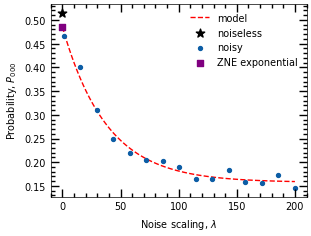

 50%|█████     | 1/2 [00:07<00:07,  7.39s/it]

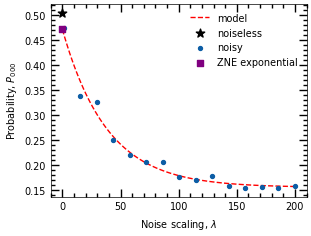

100%|██████████| 2/2 [00:14<00:00,  7.08s/it]



histograms


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]



error comparison


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


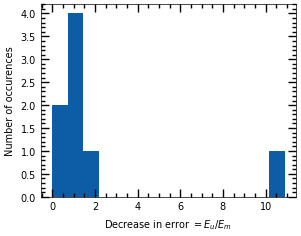

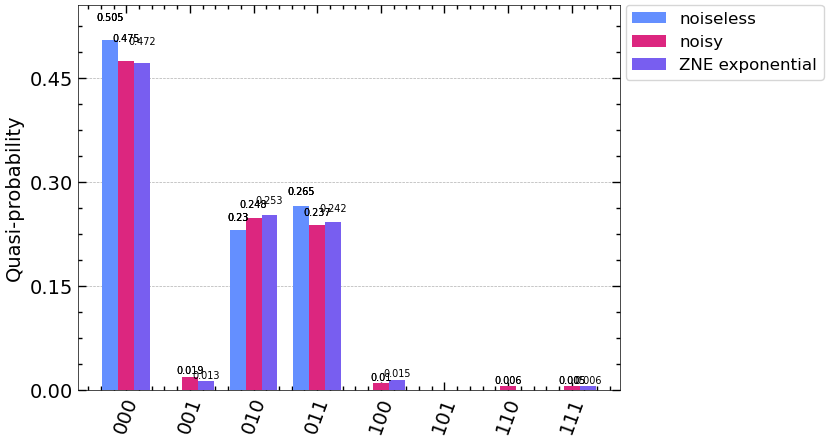



------  Statistics  ------


c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


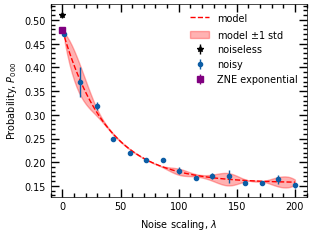

c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_

None

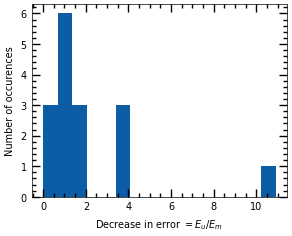

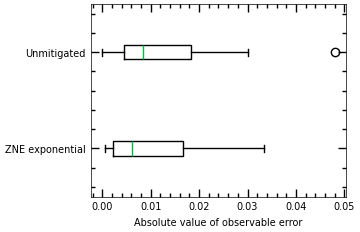

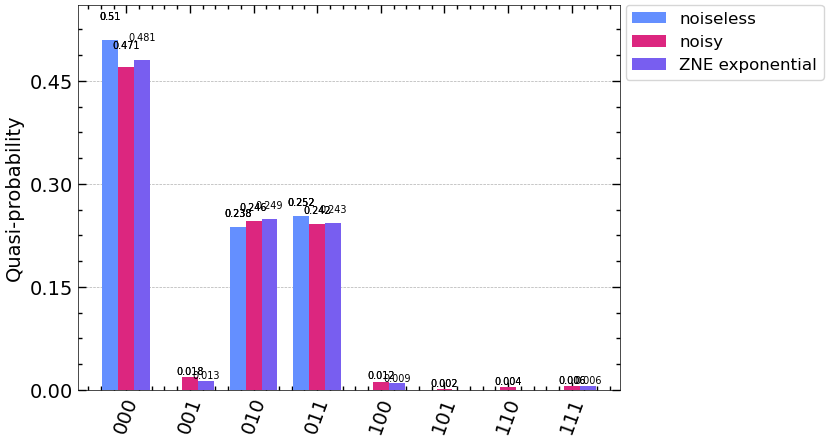

In [101]:
if __name__ == '__main__' :
    possible_outputs = ['000', '010', '011', '001', '100', '110', '111', '101']
    Nshots = 1000
    depolarizing_noise = 0.01
    noise_type = 'fake_perth'  # 'fake_perth', 'depolarizing'
    noise_levels = np.linspace(1, 200, 15)
    nreps = 2
    sim_folder = 'ZNE_exp'
    # accepted zne_type: 'exp', 'rich_d3', 'lin', 'quad'
    zne_type = 'exp'

    params_noise = [depolarizing_noise]

    doit(   sim_folder, zne_type, nreps, circuit_folding, possible_outputs, 
            Nshots, noise_type, noise_levels, *params_noise)

### Typical workflow 1 - high-level functions

In [102]:
if __name__ == '__main__' :
    possible_outputs = ['000', '010', '011', '001', '100', '110', '111', '101']
    Nshots = 1000
    depolarizing_noise = 0.01
    noise_type = 'depolarizing'  # or 'fake_perth'
    noise_levels = np.linspace(1, 200, 15)
    nreps = 2
    sim_folder = 'ZNE_exp'
    # accepted zne_type: 'exp', 'rich_d3', 'lin', 'quad'
    zne_type = 'lin'

    params_noise = [depolarizing_noise]


data generation


100%|██████████| 2/2 [00:17<00:00,  8.62s/it]




mitigation analysis


  0%|          | 0/2 [00:00<?, ?it/s]

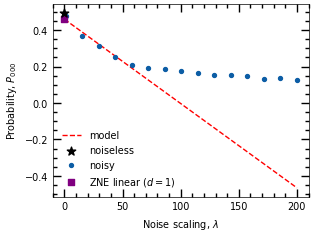

 50%|█████     | 1/2 [00:05<00:05,  5.03s/it]

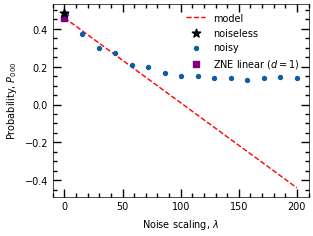

100%|██████████| 2/2 [00:09<00:00,  4.92s/it]



histograms


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]



error comparison


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


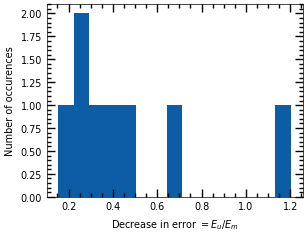

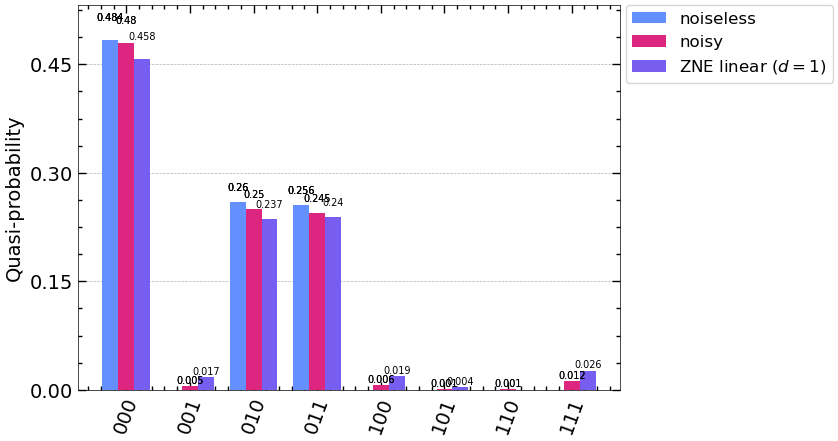

In [103]:
if __name__ == '__main__' :
    last_vals, last_legend, Eu, Em = main_create_data(sim_folder, zne_type, nreps, circuit_folding, possible_outputs, 
                    Nshots, noise_type, noise_levels, *params_noise
                    )

    plt.hist(Eu / Em, bins=15)
    plt.xlabel(r'Decrease in error $= E_u/E_m$')
    plt.ylabel(r'Number of occurences')
    plt.show()

    display(plot_histogram(last_vals, legend=last_legend))

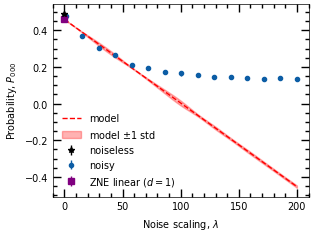

100%|██████████| 2/2 [00:00<00:00, 1002.58it/s]


None

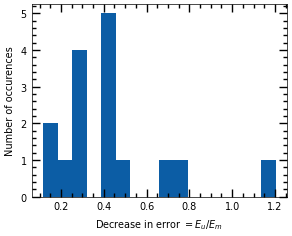

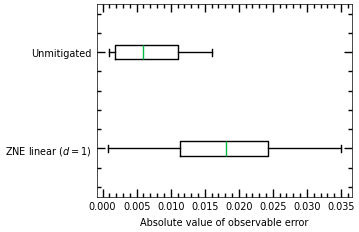

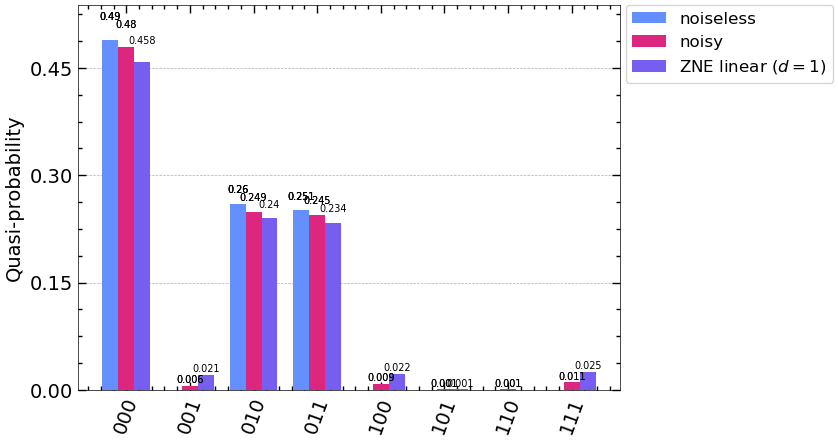

In [104]:
if __name__ == '__main__' :
    last_vals, last_legend, Eu, Em = main_stats(sim_folder, zne_type, nreps, possible_outputs, noise_levels)

    ratio = Eu / Em

    plt.hist(ratio, bins=16)
    plt.xlabel(r'Decrease in error $= E_u/E_m$')
    plt.ylabel(r'Number of occurences')
    plt.savefig(fname=f'./results/{sim_folder}/stats/decrease_in_error.pdf')  # ZNE exponential
    plt.show()

    plt.boxplot([Em, Eu], labels=[label_of(zne_type), 'Unmitigated'],  vert=False)
    plt.xlabel('Absolute value of observable error')
    plt.savefig(fname=f'./results/{sim_folder}/stats/box_plot_ZNE.pdf')  # ZNE exponential
    plt.show()

    display(plot_histogram(last_vals, legend=last_legend))

### Typical workflow 2 - low-level functions

In [105]:
if __name__ == '__main__' :
    possible_outputs = ['000', '010', '011', '001', '100', '110', '111', '101']
    Nshots = 1000
    depolarizing_noise = 0.01
    noise_type = 'depolarizing'  # or 'fake_perth'
    noise_levels = np.linspace(1, 200, 15)
    nreps = 2
    sim_folder = 'ZNE_exp'
    zne_type = 'rich_d3'

    params_noise = [depolarizing_noise]


data generation


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\



mitigation analysis


  0%|          | 0/2 [00:00<?, ?it/s]

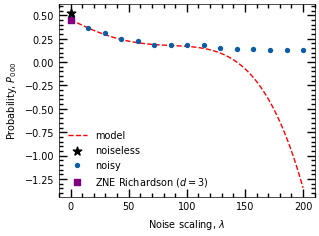

 50%|█████     | 1/2 [00:05<00:05,  5.40s/it]

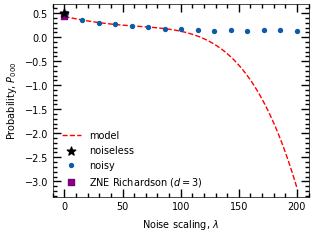

100%|██████████| 2/2 [00:10<00:00,  5.16s/it]



error comparison


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


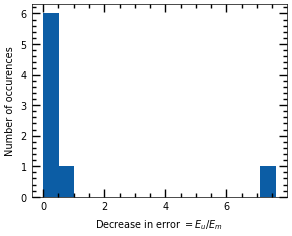


histograms


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


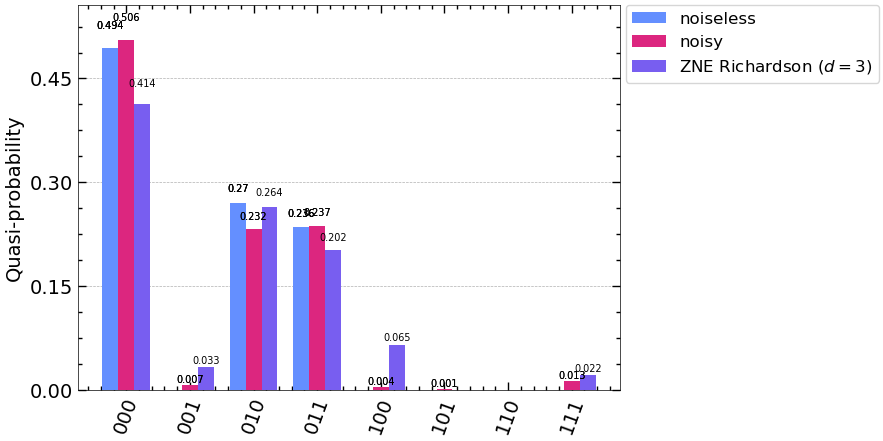

In [106]:
if __name__ == '__main__' :
    # generate data
    create_run_circuits(sim_folder, zne_type, nreps, circuit_folding, possible_outputs, 
                        Nshots, noise_type, noise_levels, *params_noise
                        )

    plot_mitigation_analysis(sim_folder, zne_type, nreps, possible_outputs, noise_levels)

    Eu, Em = save_decrease_in_error(sim_folder, nreps, possible_outputs)
    plt.hist(Eu / Em, bins=15)
    plt.xlabel(r'Decrease in error $= E_u/E_m$')
    plt.ylabel(r'Number of occurences')
    plt.show()

    last_vals, last_legend = save_comparison_histogram(sim_folder, zne_type, nreps)
    display(plot_histogram(last_vals, legend=last_legend))  

C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)


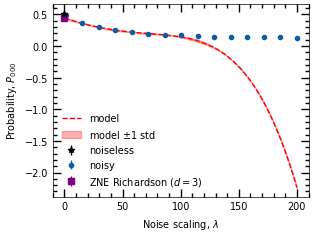

C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_6680\518727864.py:30: RankWarning: Polyfit may be poorly conditioned
  coefficients = fit_polynomial(x, y, degree)
C:\Users\antho\AppData\Local\Temp\ipykernel_66

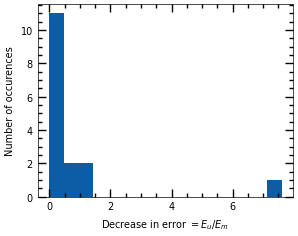

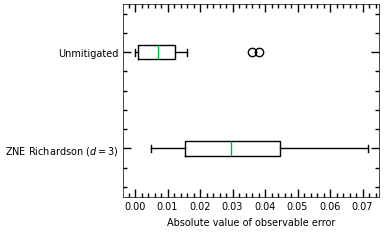

None

In [107]:
if __name__ == '__main__' :
    compute_statistics(sim_folder, nreps, possible_outputs, noise_levels)

    save_statistics(sim_folder, zne_type, possible_outputs, noise_levels)
    plt.show()

    Eu, Em = save_error_stats(sim_folder, nreps, possible_outputs)
    ratio = Eu / Em

    plt.hist(ratio, bins=16)
    plt.xlabel(r'Decrease in error $= E_u/E_m$')
    plt.ylabel(r'Number of occurences')
    plt.savefig(fname=f'./results/{sim_folder}/stats/decrease_in_error.pdf')  # ZNE exponential
    plt.show()

    plt.boxplot([Em, Eu], labels=[label_of(zne_type), 'Unmitigated'],  vert=False)
    plt.xlabel('Absolute value of observable error')
    plt.savefig(fname=f'./results/{sim_folder}/stats/box_plot_ZNE.pdf')  # ZNE exponential
    plt.show()

    last_vals, last_legend = save_comparison_histogram_stats(sim_folder, zne_type, possible_outputs)
    plot_histogram(last_vals, legend=last_legend)


# Generalisation QFT to n qubits

for comparison: check that the result is correct

In [46]:
def prepare_input_state(qc) :
    qc.h(0)
    qc.x(1)
    qc.h(2)
    return qc

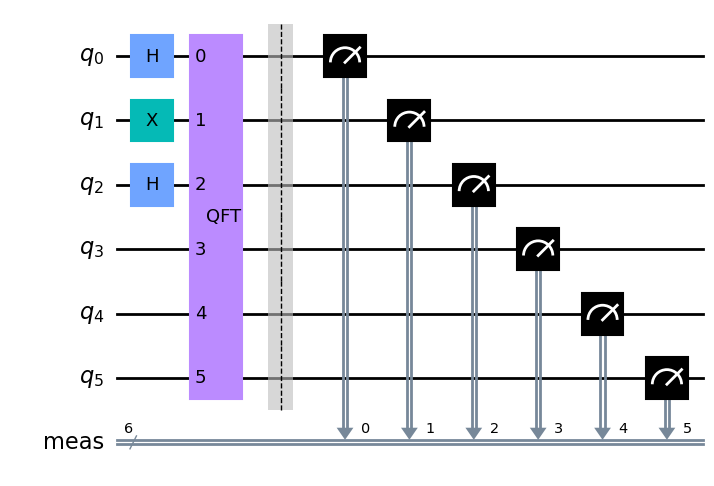

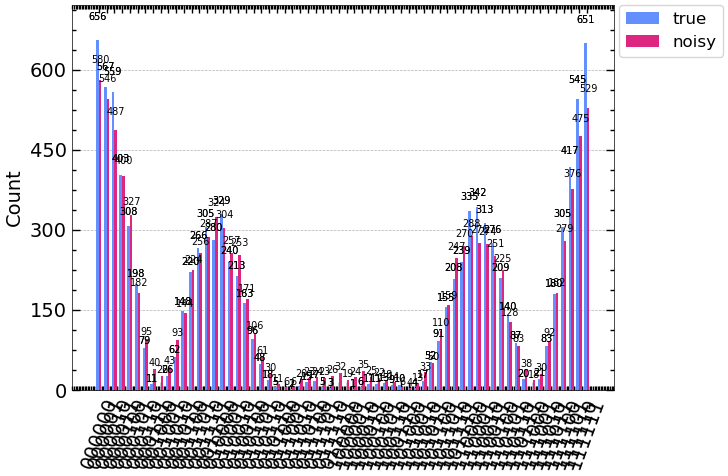

In [101]:
if __name__ == '__main__' :

    from qiskit.circuit.library import QFT

    n=6

    pi = np.pi

    q = QuantumRegister(n,'q')

    circuit = QuantumCircuit(q)

    prepare_input_state(circuit)
    gate_qft = QFT(num_qubits=n, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=True, name='QFT').to_instruction()
    circuit.append(gate_qft, [i for i in range(n)])
    circuit.measure_all()
    display(circuit.draw(output='mpl'))

    Nshots = 10000
    results_true = run_true(circuit, Nshots)
    results_noisy = run_noisy(circuit, Nshots, 'fake_perth')
    display(plot_histogram([results_true.get_counts(), results_noisy.get_counts()], legend=['true', 'noisy']))       # , color=['green', 'red'])


### QFT for a n-qubits circuit: building + manipulations for folding 

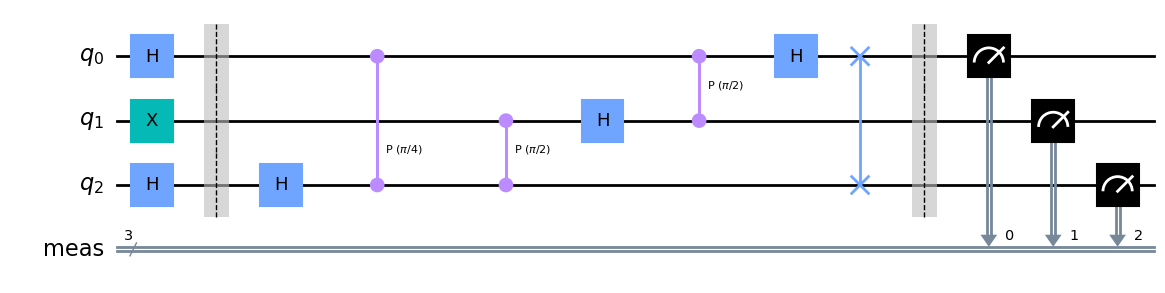

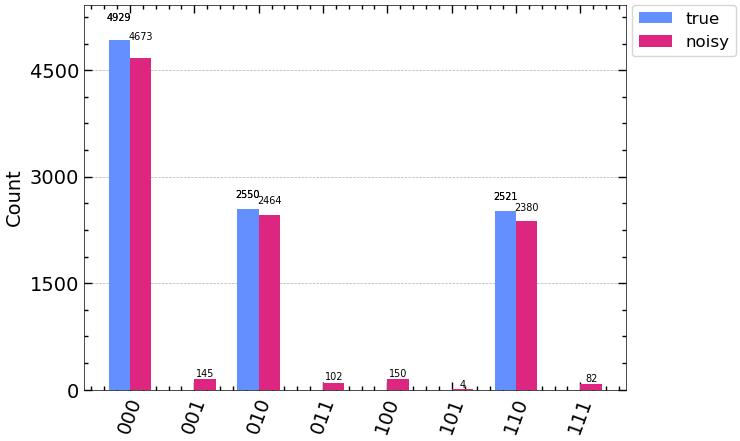

In [243]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)
    
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


def split_in_layers(qc) :
    layers = []
    dag = circuit_to_dag(qc)
    for layer in dag.layers():
        layer_as_circuit = dag_to_circuit(layer['graph'])
        layers.append(layer_as_circuit)
    return layers


def add_layers(qc, layers, n_qubit) :
    for l in layers :
        qc = qc.compose(l, qubits=range(n_qubit))
    return qc


def list_layers_dagger(layers, n_qubit) :
    Lt = []
    for l in layers :
        counter = 0
        for gate in l.data:
            if len(l.data) == 1 :
                if gate[0].name == 'cp' :
                    conjugate_layer = QuantumCircuit(n_qubit)
                    conjugate_layer.cp(-gate[0].params[0], gate[1][0], gate[1][1])
                else :
                    conjugate_layer = l
                Lt.insert(0, conjugate_layer)
            else :
                if counter == 1 :
                    conjugate_layer = l
                    Lt.insert(0, conjugate_layer)
                counter += 1
    return Lt


def create_qft(n_qubit) :
    qc = QuantumCircuit(n_qubit)
    qc_qft = qft(qc,n_qubit)
    L = split_in_layers(qc_qft)
    return qc_qft, L


def create_qft_inv(n_qubit) :
    qc = QuantumCircuit(n_qubit)
    qc_qft = qft(qc,n_qubit)
    L = split_in_layers(qc_qft)
    L_dagger = list_layers_dagger(L, n_qubit)
    qc = add_layers(QuantumCircuit(n_qubit), L_dagger, n_qubit)
    return qc, L_dagger


def qc_U(n_qubit) :
    return create_qft(n_qubit)


def qc_Ut(n_qubit) :
    return create_qft_inv(n_qubit)


if __name__ == '__main__' :
    n = 3
    qc = QuantumCircuit(n)
    prepare_input_state(qc)
    qc.barrier()
    qft(qc,n)

    qc.measure_all()
    display(qc.draw('mpl'))


    Nshots = 10000
    results_true = run_true(qc, Nshots)
    results_noisy = run_noisy(qc, Nshots, 'fake_perth')
    display(plot_histogram([results_true.get_counts(), results_noisy.get_counts()], legend=['true', 'noisy']))       # , color=['green', 'red'])



### Tools for manipulating circuits

In [305]:
# tools
def merge_circuits(qc1, qc2, n, barrier=False) :
    qc_tot = QuantumCircuit(n)
    qc_tot = qc_tot.compose(qc1, qubits=range(n))
    if barrier == True :
        qc_tot.barrier()
    qc_tot = qc_tot.compose(qc2, qubits=range(n))
    return qc_tot


def merge_circuits_list(n, *args) :
    qc_tot = QuantumCircuit(n)
    for i, qc_list in enumerate(args) :
        for qc in qc_list :
            qc_tot = merge_circuits(qc_tot, qc, n)
        if i != len(args)-1 :
            qc_tot.barrier()
    return qc_tot


def insert_input_state(qc, n_qubits) :
    qc_tot = QuantumCircuit(n_qubits)
    prepare_input_state(qc_tot)
    return merge_circuits(qc_tot, qc, n_qubits, barrier=True)


### Folding

In [452]:
def build_full_circuit(n, *layers) :
    """
    Constructs a quantum circuit consisting of multiple layers of operations.

    Args:
    - layers (list): A list of Q-CIRCUITS representing quantum operations for each layer.
                     Each function should take a QuantumCircuit as its argument and apply
                     quantum gates or operations to it.

    Returns:
    - QuantumCircuit: A constructed quantum circuit with the specified layers of operations.
                      The layers are applied sequentially with barriers between each layer,
                      and measurements are added to all qubits at the end of the circuit.
    """
    qc = merge_circuits_list(n, *layers)
    qc = insert_input_state(qc, n)
    qc.measure_all()
    return qc


def select_layers_from_left(d, s, L, Lt) :
    """
    Selects layers from left based on the provided parameters.

    Args:
    - d (int): The total number of layers.
    - s (int): The number of layers to select from the left.

    Returns:
    - list: A list containing selected layers from the left based on the parameters.
        
    Example:
    s = 3, d = 8 returns:
    [L7t L6t L5t L5 L6 L7]
    """  
    Ls = L[d-s:]
    Lst = Lt[:s]
    return Lst + Ls


def loop(G, Gt, n) :
    """
    Constructs a list representing a loop of gates and their dagger counterparts.

    Args:
    - G: A quantum gate or operation.
    - Gt: The dagger (conjugate transpose) of the gate 'G'.
    - n (int): The number of repetitions for constructing the loop.

    Returns:
    - list: A list containing the gates and their dagger counterparts forming a loop.
            The list alternates between 'Gt' and 'G' repeated 'n' times.

    Example:
    n=2 returns the list of gates corresponding to
    (Gt*G)**2
    """
    L = []
    for i in range(n):
        L.append(Gt)
        L.append(G)
    return L


def circuit_folding(target_noise_levels, num_bits, sim_folder, circuits_exist=False) :
    """
    Constructs a folded quantum circuit based on target noise levels.

    Args:
    - target_noise_levels (array of floats): The desired noise levels for the folded circuit.

    Returns:
    - Tuple: A tuple containing the calculated noise levels after folding and the folded quantum circuit.
             The folding process involves constructing a folded circuit based on the target noise levels.
             The folded circuit comprises multiple layers of quantum gates and their repetitions 
             based on the noise levels and predefined parameters.
    """
    L_tmp = qc_U(num_bits)[1]
    Lt_tmp = qc_Ut(num_bits)[1]

    d = len(L_tmp)   
    ks, ns, ss = closest_integer(target_noise_levels, d)
    noise_levels = 1 + 2 * ks / d
    
    qc_list = []
    layers_list = []
    print('Building circuits')
    for n, s, lbda in tqdm(zip(ns, ss, noise_levels)):
        if circuits_exist == True :
            qc = pickle_load(filename=f'results/{sim_folder}/circuits/{lbda:.1f}.qc')
            qc_list.append(qc)
        else :
            l = [L_tmp, *loop(L_tmp, Lt_tmp, n), select_layers_from_left(d, s, L_tmp, Lt_tmp)]
            layers_list.append(l)
            qc = build_full_circuit(num_bits, *l)
            qc_list.append(qc)
            qc.draw('mpl', filename=f'results/{sim_folder}/circuits/{lbda:.1f}.pdf')
            pickle_save(qc, filename=f'results/{sim_folder}/circuits/{lbda:.1f}.qc')
    
    return noise_levels, qc_list, layers_list

def layer_folding(target_noise_levels, num_bits, sim_folder, circuits_exist=False) :
    L_tmp = qc_U(num_bits)[1]
    Lt_tmp = qc_Ut(num_bits)[1]

    d = len(L_tmp)   
    ks, ns, ss = closest_integer(target_noise_levels, d)
    noise_levels = 1 + 2 * ks / d

    qc_list = []
    layers_list = []
    print('Building circuits')
    for n, s, lbda in tqdm(zip(ns, ss, noise_levels)):
        if circuits_exist == True :
            qc = pickle_load(filename=f'results/{sim_folder}/circuits/{lbda:.1f}.qc')
            qc_list.append(qc)
        else :
            layers_list = []
            qc = QuantumCircuit(num_bits)
            qc_tot = QuantumCircuit(num_bits)

            for j, Lj in enumerate(L_tmp) :
                if j < s :
                    l = [Lj, *loop(Lj, Lt_tmp[d-1-j], n+1)]
                    layers_list += l
                else : 
                    l = [Lj, *loop(Lj, Lt_tmp[d-1-j], n)]
                    layers_list += l
                qc = merge_circuits_list(num_bits, l)
                if j != len(L_tmp)-1 :
                    qc.barrier()
                qc_tot = merge_circuits(qc_tot, qc, num_bits)
            qc_tot.measure_all()
            qc_tot = insert_input_state(qc_tot, num_bits)
            qc_list.append(qc_tot)
            qc.draw('mpl', filename=f'results/{sim_folder}/circuits/{lbda:.1f}.pdf')
            pickle_save(qc, filename=f'results/{sim_folder}/circuits/{lbda:.1f}.qc')               
    
    return noise_levels, qc_list, layers_list
    

### Updated workflow

circuit folding



------  Simulations  ------
Building circuits


4it [00:02,  1.89it/s]



data generation


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 50%|█████     | 1/2 [00:03<00:03,  3.81s/it]c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 2/2 [00:06<00:00,  3.29s/it]




mitigation analysis


  0%|          | 0/2 [00:00<?, ?it/s]

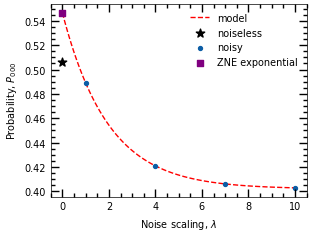

 50%|█████     | 1/2 [00:03<00:03,  3.67s/it]

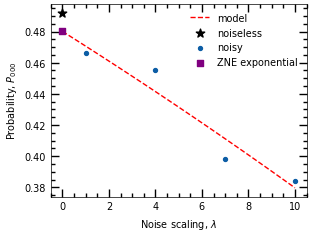

100%|██████████| 2/2 [00:07<00:00,  3.57s/it]



histograms


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]



error comparison


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


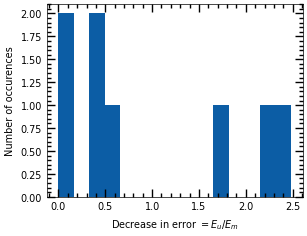

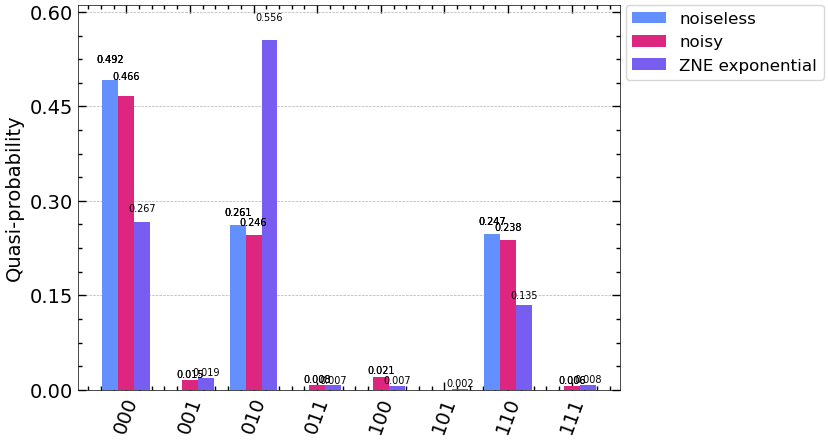



------  Statistics  ------


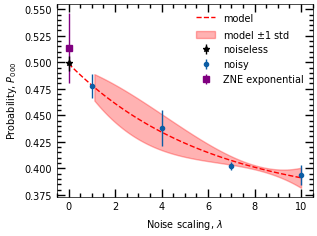

c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 2/2 [00:00<00:00, 2309.00it/s]


None

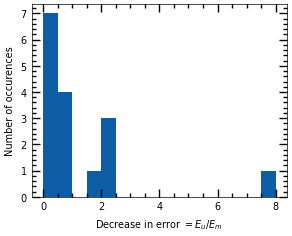

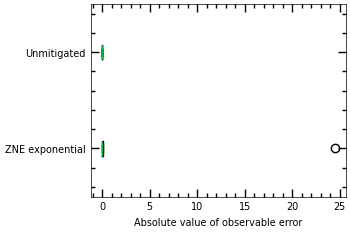

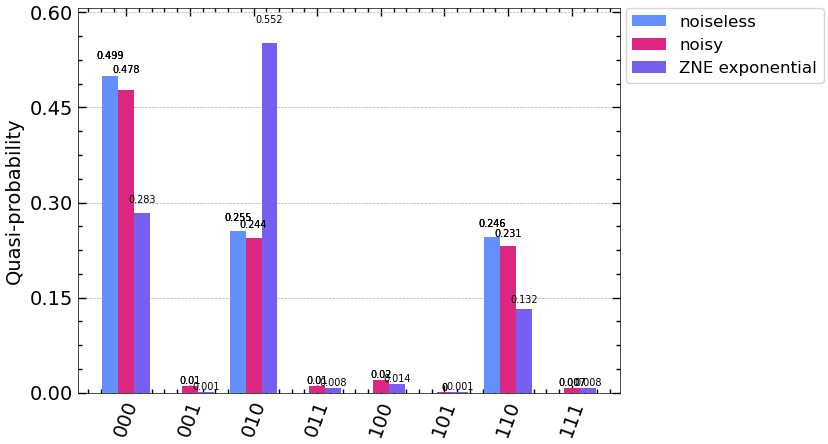

In [166]:
if __name__ == '__main__' :

    n_qubits = 3
    possible_outputs = generate_binary_values(n_qubits)

    Nshots = 1000
    noise_levels = np.linspace(1, 10, 4)
    depolarizing_noise = 0.01
    noise_type = 'fake_perth'  # 'fake_perth', 'depolarizing'
    params_noise = [depolarizing_noise]

    nreps = 2

    # accepted zne_type: 'exp', 'rich_d3', 'lin', 'quad'
    zne_type = 'exp'
    sim_folder = 'ZNE_exp'

    run_existing_circuits = False

    folding = lambda x: circuit_folding(x, num_bits=n_qubits, sim_folder=sim_folder, circuits_exist=run_existing_circuits)

    doit(sim_folder, zne_type, nreps, folding, possible_outputs, 
        Nshots, noise_type, noise_levels, *params_noise)

layer folding



------  Simulations  ------
Building circuits


0it [00:00, ?it/s]

10it [00:03,  2.97it/s]



data generation


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 50%|█████     | 1/2 [00:04<00:04,  4.44s/it]c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 2/2 [00:09<00:00,  4.77s/it]




mitigation analysis


  0%|          | 0/2 [00:00<?, ?it/s]

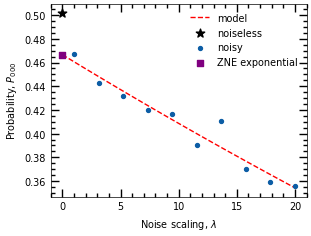

 50%|█████     | 1/2 [00:02<00:02,  2.86s/it]

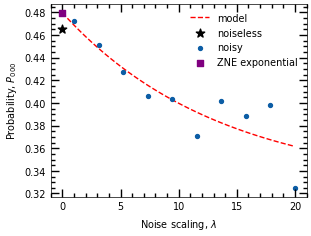

100%|██████████| 2/2 [00:06<00:00,  3.27s/it]



histograms


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]



error comparison


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


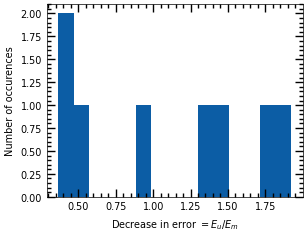

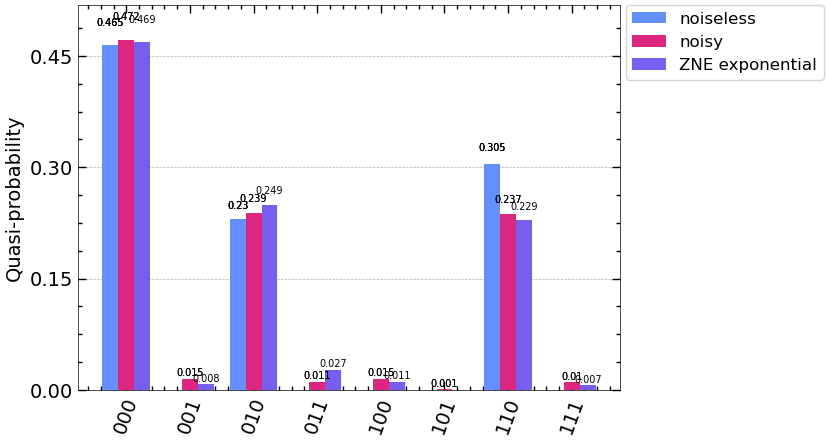



------  Statistics  ------


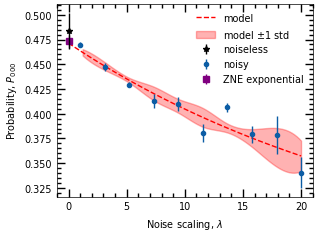

c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\antho\miniconda3\envs\qiskit\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 2/2 [00:00<00:00, 998.05it/s]


None

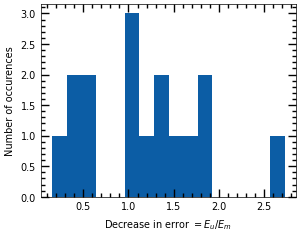

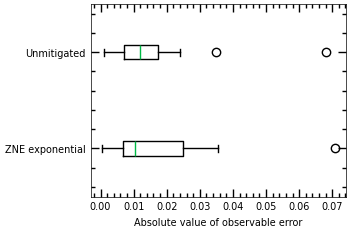

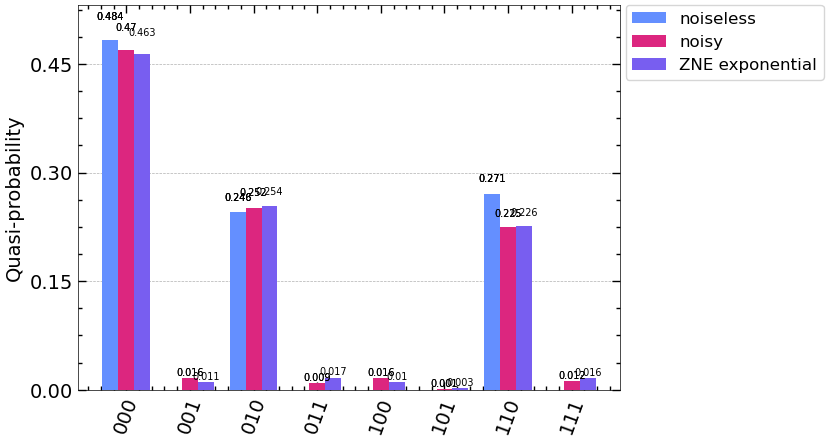

In [461]:
if __name__ == '__main__' :

    n_qubits = 3
    possible_outputs = generate_binary_values(n_qubits)

    Nshots = 1000
    noise_levels = np.linspace(1, 20, 10)
    depolarizing_noise = 0.01
    noise_type = 'fake_perth'  # 'fake_perth', 'depolarizing'
    params_noise = [depolarizing_noise]

    nreps = 2

    # accepted zne_type: 'exp', 'rich_d3', 'lin', 'quad'
    zne_type = 'exp'
    sim_folder = 'ZNE_exp_layer'

    run_existing_circuits = False    

    folding = lambda x: layer_folding(x, num_bits=n_qubits, sim_folder=sim_folder, circuits_exist=run_existing_circuits)


    doit(sim_folder, zne_type, nreps, folding, possible_outputs, 
        Nshots, noise_type, noise_levels, *params_noise)
    

display some circuits

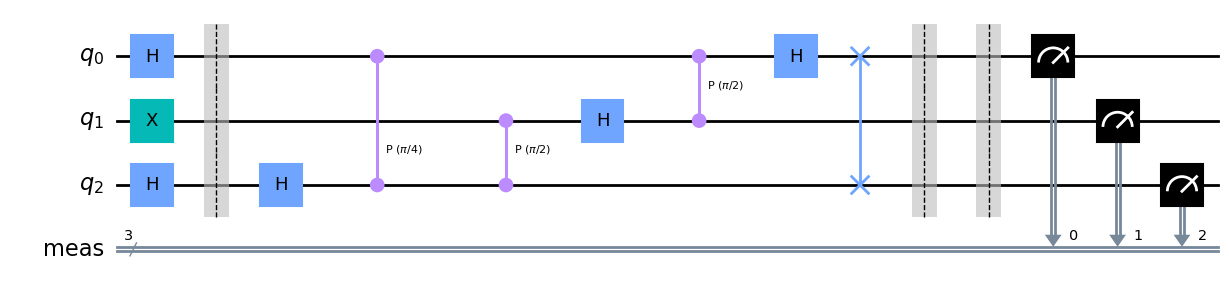

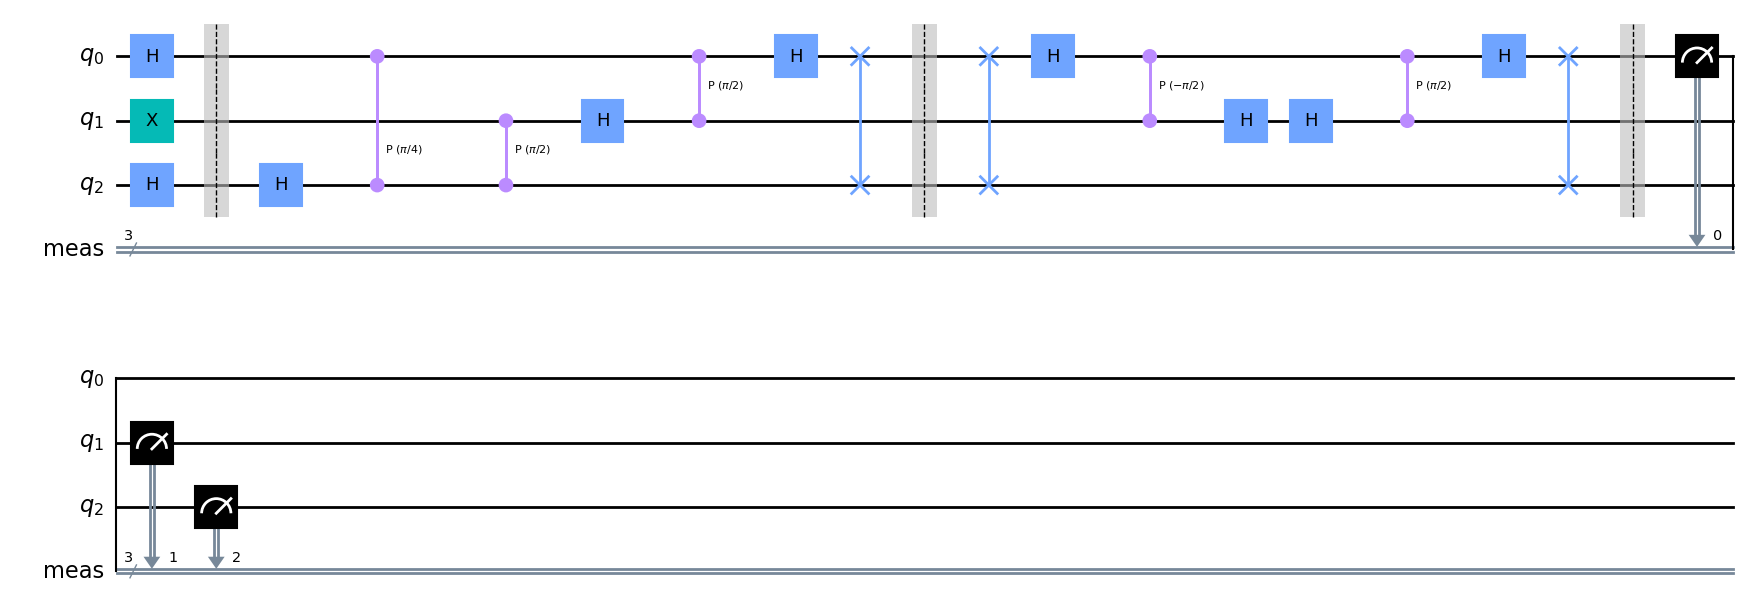

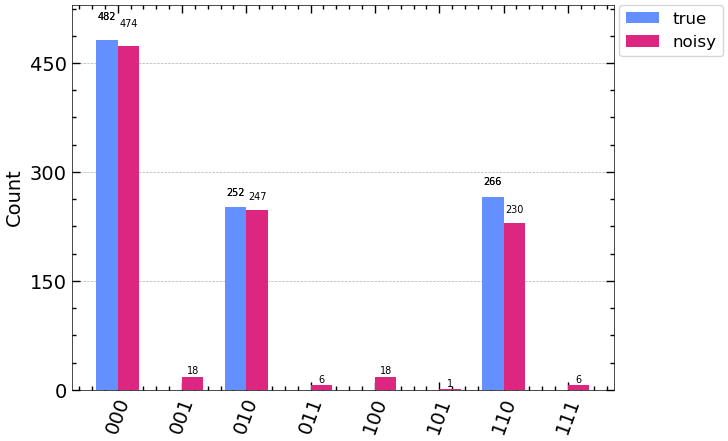

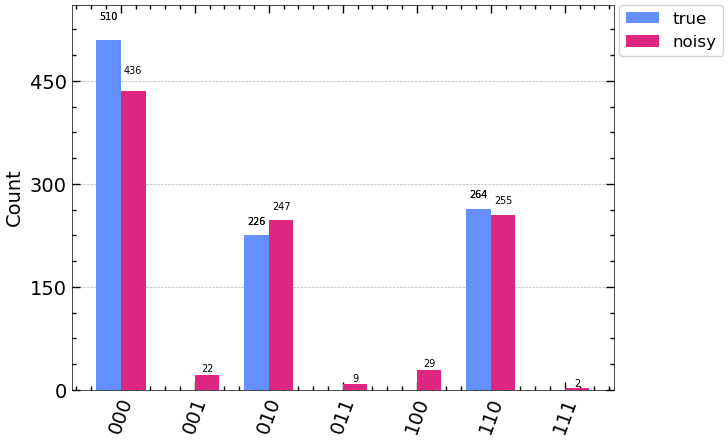

In [71]:
if __name__ == '__main__' :
    n = 3
    noise_levels = np.array([1, 2.3])
    lambdas, qc_list, _ = circuit_folding(noise_levels, n)


    for qc in qc_list :
        display(qc.draw(output='mpl'))


    for qc in qc_list :
        Nshots = 1000
        results_true = run_true(qc, Nshots)
        results_noisy = run_noisy(qc, Nshots, 'fake_perth')
        display(plot_histogram([results_true.get_counts(), results_noisy.get_counts()], legend=['true', 'noisy']))       # , color=['green', 'red'])
        